# Previsão de Churn de Clientes - Desafio Ensembles

### Resolução por Caroline Dalmazzo

### Objetivo:

Nesse desafio, construído em uma parceria da Tera e o Luizalabs, o objetivo principal será construir algumas soluções baseadas em machine learning para prever se um dado cliente do e-commerce do Magalu continuará comprando na plataforma em 2020 usando algumas características próprias do cliente e seu histórico de compras no ano anterior. No final, algumas dessas soluções devem ser combinadas em um ensemble para criar uma solução única com o objetivo de alavancar ainda mais os resultados.

Para que o objetivo principal seja cumprido, será necessário construir uma forma de visualização das soluções criadas e a comparação com o modelo baseline e com o modelo de ensemble criados no processo.

Também é uma boa prática avaliar os modelos treinados, seja através da exploração de seus parâmetros (por exemplo, os pesos de um modelo linear) ou usando técnicas avançadas como o SHAP.

O desafio também possui um dataset de pontuação, contendo dados de clientes que não estão nem nas bases de treino nem nas de teste. Para esses clientes não foram disponibilizadas as respostas (targets), sendo portanto impossível verificar durante o desenvolvimento da solução se o modelo está acertando ou não.

### Base de dados:

Os dados sensíveis ou privados de clientes e produtos estão todos anonimizados, respeitando a privacidade dos mesmos e evitando o vazamento de informações estratégicas da empresa.

Esses dados anonimizados incluem informações de IDs de entidades (clientes, vendas e produtos), os estados de origem do cliente e de destino do produto e a estrutura mercadológica dos produtos (nomes de categorias e subcategorias às quais pertencem), assim como sua descrição (nome do produto incluso).

Os dados de clientes estão contidos em 3 arquivos csv já separados em treino, teste e desafio.

*   client_id: ID global único do cliente;
*   birthdate: data de nascimento do cliente;
*   state: estado onde o cliente mora;
*   gender: gênero declarado pelo cliente;
*   is_churn: variável dependente (target) que diz se o cliente será churn ou não.

As colunas da Tabela de Produtos são todas simbólicas, representando as diferentes categorias da árvore de Estrutura Mercadológica onde o produto está inserido.

Os nomes das subcategorias herdam o nome da categoria pai, de forma que todas as subcategorias da coluna category_lv2 que começam com "mk38:072" possuem como categoria pai a category_lv1 de nome "mk38:072", que por sua vez é filho da category_lv0 de nome "mk38".

Um exemplo da categorização:

*   category_lv0: Categorias mais abrangentes dos produtos; e.g. "Eletrônicos" ou "Moda"
*   category_lv1: Subcategorias; e.g. "Eletrônicos->Notebooks"
*   category_lv2: Sub-subcategorias; e.g. "Eletrônicos->Notebooks->UltraFinos"

e assim por diante.

A coluna product_id é a referência global de produtos, que pode ser combinada por merge com a tabela de vendas.

Os dados do histórico de todas as vendas de 2019 para todos os clientes nos 3 datasets de cliente que compraram qualquer produto - todos contidos no dataset de produtos.

As colunas dessa tabela estão descritas a seguir.

As colunas de ID de entidade são:

*   order_id: identificador da venda; pode estar repetida em outras linhas, pois cada linha corresponde à compra de um produto por um cliente, que pode ter comprado outros produtos no mesmo evento;
*   client_id: identificador do cliente que realizou a compra;
*   datetime: data e hora da compra;
*   units: quantidade de unidades do produto que foram comprados nesse evento de compra;
*   price: preço unitário do produto comprado;
*   payment_method: forma de pagamento (crétido, débito, voucher, etc) da compra;
*   installments: número de parcelas do pagamento; se estiver vazio, pode-se considerar que não se aplica;
*   delivery_days: prazo de entrega do produto;
*   delivery_state: estado onde ocorreu a entrega do produto; corresponde exatamente ao estado nas tabelas de cliente;
*   device: meio por onde o cliente comprou; e.g. site, aplicativo do celular, terminal de compras;
*   source: canal de marketing que gerou o lead e ocasionou ao cliente comprar; por exemplo, pode ser um link em uma página parceira onde o cliente viu uma promoção.

### Aquisição dos Dados:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Bibliotecas processamento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Métricas
from sklearn.metrics import accuracy_score, recall_score,f1_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

# Classifier Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Feature importance
from sklearn.inspection import permutation_importance

# Ensembles
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clients_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/client.train.csv")
clients_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/client.test.csv")
clients_challenge = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/client.challenge.data.csv")
orders = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/orders.csv")
product = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/product.csv")

In [ ]:
clients_train.head()

,client_id,birthdate,state,gender,is_churn
0,cx05072,1972-03-22,st25,cg2,False
1,cx03836,1966-08-14,st15,cg1,False
2,cx08472,1954-08-07,st15,cg1,False
3,cx12946,1955-11-16,st15,cg1,False
4,cx19045,1958-10-25,st15,cg2,False


In [ ]:
clients_train.shape

(23292, 5)

In [ ]:
clients_test.head()

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [ ]:
clients_test.shape

(7764, 5)

In [ ]:
clients_challenge.head()

,client_id,birthdate,state,gender
0,cx12525,1932-04-19,st15,cg1
1,cx32280,1983-03-01,st15,cg1
2,cx00471,1964-08-30,st15,cg2
3,cx18876,1971-04-27,st15,cg2
4,cx38255,1958-01-26,st15,cg1


In [ ]:
clients_challenge.shape

(7765, 4)

In [ ]:
orders.head()

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
3,ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
4,ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.0,pm05,NaN,NaN,st07,dv9,sc08


In [ ]:
orders.shape

(168472, 12)

In [ ]:
product.head()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
3,px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
4,px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218


In [ ]:
product.shape

(12659, 6)

### Análise Exploratória:

In [ ]:
clients_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23292 entries, 0 to 23291
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  23292 non-null  object
 1   birthdate  23292 non-null  object
 2   state      23292 non-null  object
 3   gender     23292 non-null  object
 4   is_churn   23292 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 750.7+ KB


In [ ]:
clients_train.isna().sum()

client_id    0
birthdate    0
state        0
gender       0
is_churn     0
dtype: int64

In [ ]:
clients_train.describe(include='all')

,client_id,birthdate,state,gender,is_churn
count,23292,23292,23292,23292,23292
unique,23292,13046,27,2,2
top,cx05072,1990-01-01,st15,cg1,False
freq,1,58,8201,12879,19085


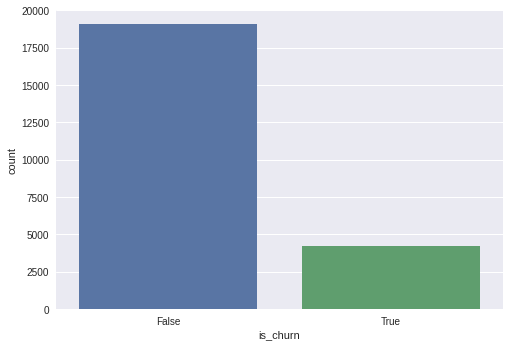

In [ ]:
sns.countplot(data=clients_train, x='is_churn')
plt.show()

In [ ]:
clients_train.value_counts('is_churn', normalize=True)

is_churn
False    0.81938
True     0.18062
dtype: float64

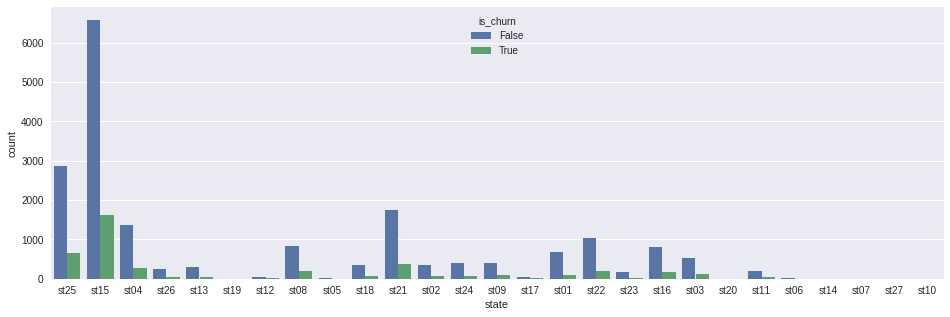

In [ ]:
plt.figure(figsize=(16,5))
sns.countplot(data=clients_train, x='state', hue='is_churn')
plt.show()

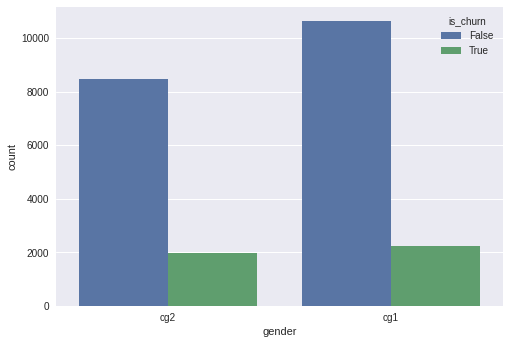

In [ ]:
sns.countplot(data=clients_train, x='gender', hue='is_churn')
plt.show()

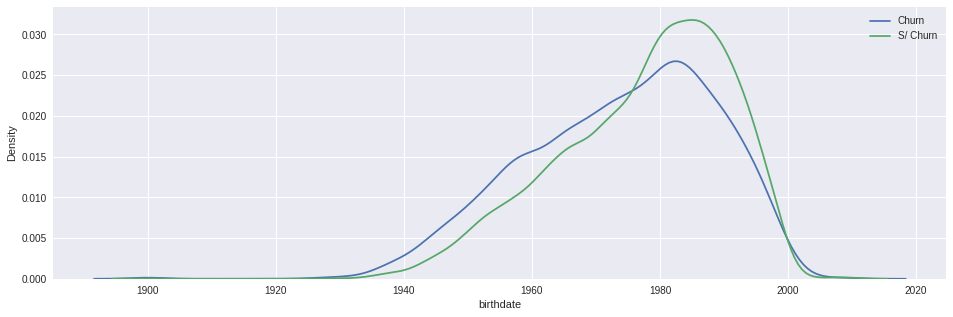

In [ ]:
plt.figure(figsize=(16,5))
sns.kdeplot(clients_train[clients_train['is_churn']==True]['birthdate'].str[:4].astype(int))
sns.kdeplot(clients_train[clients_train['is_churn']==False]['birthdate'].str[:4].astype(int))
plt.legend(labels=["Churn","S/ Churn"])
plt.show()

In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12659 entries, 0 to 12658
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    12659 non-null  object
 1   category_lv0  12659 non-null  object
 2   category_lv1  12659 non-null  object
 3   category_lv2  12659 non-null  object
 4   category_lv3  12659 non-null  object
 5   category_lv4  12659 non-null  object
dtypes: object(6)
memory usage: 593.5+ KB


In [ ]:
product.isna().sum()

product_id      0
category_lv0    0
category_lv1    0
category_lv2    0
category_lv3    0
category_lv4    0
dtype: int64

In [ ]:
product.describe()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
count,12659,12659,12659,12659,12659,12659
unique,12659,52,296,893,1218,10763
top,px01237,mk17,mk21:089,mk03:092:378,mk03:092:378:103,mk35:072:177:182:09721
freq,1,1273,563,237,237,10


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168472 entries, 0 to 168471
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
dtypes: float64(4), object(8)
memory usage: 15.4+ MB


In [ ]:
orders.isna().sum()

order_id               0
client_id              0
product_id             0
datetime               0
units                  0
price                  0
payment_method         0
installments      131927
delivery_days      78830
delivery_state         0
device                 0
source                 0
dtype: int64

In [ ]:
orders.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,units,price,installments,delivery_days
count,168472.000000,168472.000000,36545.000000,89642.000000
mean,1.228846,451.384291,4.551293,7.017938
std,1.504511,857.769280,4.704385,6.855334
min,0.000000,-8999.000000,1.000000,0.000000
1%,0.190946,-1499.900000,1.000000,0.000000
5%,1.000000,-98.900000,1.000000,0.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,162.580000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000
95%,2.000000,2050.000000,12.000000,20.000000


In [ ]:
orders.describe(include='object')

,order_id,client_id,product_id,datetime,payment_method,delivery_state,device,source
count,168472,168472,168472,168472,168472,168472,168472,168472
unique,133209,38821,12535,102263,14,26,9,16
top,ox059501,cx33292,px10485,2019-11-29 10:29:00,pm05,st07,dv9,sc08
freq,5,101,1875,41,131927,97820,97794,97796


In [ ]:
train_merged = pd.merge(pd.merge(clients_train, orders, on='client_id'), product, on='product_id').copy()

In [ ]:
train_merged.head()

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,...,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,cx05072,1972-03-22,st25,cg2,False,ox008433,px04611,2019-10-07 15:20:00,1.0,49.90,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
1,cx09976,1979-12-23,st25,cg1,False,ox076724,px04611,2019-07-31 16:06:00,1.0,49.90,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,cx03223,1969-03-22,st15,cg2,False,ox089080,px04611,2019-01-18 12:43:00,1.0,49.89,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
3,cx38788,1987-11-11,st25,cg1,False,ox000246,px04611,2019-06-21 11:22:00,1.0,49.90,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,cx00593,1982-07-01,st15,cg1,False,ox040114,px04611,2019-07-01 18:22:00,1.0,49.90,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


In [ ]:
train_merged.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,units,price,installments,delivery_days
count,101005.000000,101005.000000,21991.000000,53813.000000
mean,1.228586,447.517332,4.531990,6.916656
std,1.564544,855.590526,4.694589,6.779945
min,0.000100,-8999.000000,1.000000,0.000000
1%,0.190200,-1515.000000,1.000000,0.000000
5%,1.000000,-98.908000,1.000000,0.000000
10%,1.000000,5.000000,1.000000,2.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,163.010000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000


In [ ]:
train_merged.describe(include='object')

,client_id,birthdate,state,gender,order_id,product_id,datetime,payment_method,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
count,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005,101005
unique,23292,13046,27,2,80190,10145,67735,14,24,9,16,51,277,814,1107,8674
top,cx04375,1990-01-01,st15,cg1,ox111696,px03347,2019-11-29 10:29:00,pm05,st07,dv9,sc08,mk21,mk21:089,mk21:089:468,mk21:089:468:103,mk21:127:505:103:00668
freq,98,194,35017,58145,5,1133,30,79014,58422,58404,58406,17503,12161,7031,7031,1133


In [ ]:
auxiliar = pd.merge(train_merged.groupby('client_id')[['units']].sum().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id') 

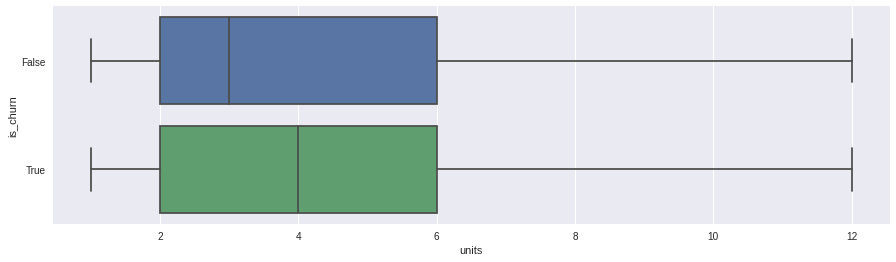

In [ ]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='units', y='is_churn', orient='h', showfliers=False)
plt.show()

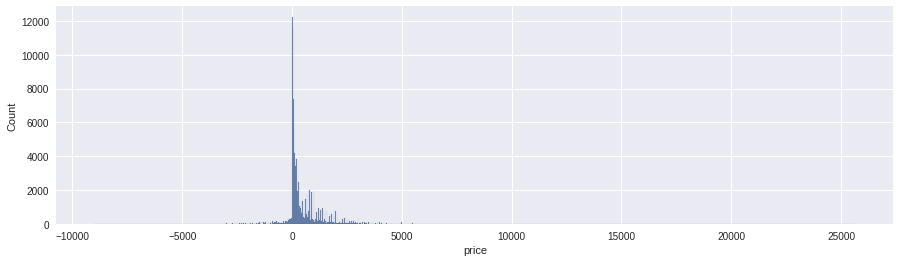

In [ ]:
plt.figure(figsize=(15, 4))
sns.histplot(data=train_merged, x='price')
plt.show()

In [ ]:
train_merged[train_merged['price']<=0]

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,...,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
9,cx03363,1974-01-31,st25,cg2,True,ox062213,px12305,2019-10-10 14:21:00,1.00000,-69.90,...,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
23,cx03836,1966-08-14,st15,cg1,False,ox090390,px11147,2019-02-08 17:29:00,1.00000,-54.92,...,NaN,NaN,st07,dv9,sc08,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
38,cx35550,1994-06-16,st22,cg2,False,ox084595,px11147,2019-03-11 14:52:00,1.00000,-42.58,...,NaN,NaN,st22,dv3,sc12,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
41,cx08267,1994-01-16,st25,cg1,True,ox127169,px11147,2019-01-28 17:33:00,1.00000,-49.00,...,NaN,NaN,st07,dv9,sc08,mk29,mk29:039,mk29:039:103,mk29:039:103:103,mk29:039:103:103:06602
52,cx28435,1943-04-03,st25,cg1,False,ox025288,px05603,2019-11-30 09:57:00,1.00000,-269.90,...,NaN,NaN,st07,dv9,sc08,mk29,mk29:171,mk29:171:103,mk29:171:103:103,mk29:171:103:103:03316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100994,cx23420,1973-10-03,st15,cg1,False,ox095310,px00775,2019-06-07 13:46:00,1.00000,-251.10,...,NaN,NaN,st15,dv3,sc12,mk52,mk52:059,mk52:059:103,mk52:059:103:103,mk52:059:103:103:09707
100996,cx02028,1971-01-28,st02,cg2,False,ox057176,px09366,2019-12-02 13:21:00,1.00000,-1200.00,...,NaN,NaN,st07,dv9,sc08,mk27,mk27:112,mk27:112:544,mk27:112:544:103,mk27:112:544:103:08008
100998,cx02028,1971-01-28,st02,cg2,False,ox072070,px09366,2019-12-07 11:43:00,1.00000,-1278.00,...,NaN,NaN,st07,dv9,sc08,mk27,mk27:112,mk27:112:544,mk27:112:544:103,mk27:112:544:103:08008
101001,cx33764,1987-10-30,st15,cg2,False,ox119488,px04922,2019-01-09 18:29:00,0.16184,-165.84,...,NaN,NaN,st07,dv9,sc08,mk13,mk13:280,mk13:280:260,mk13:280:260:103,mk13:280:260:103:10627


In [ ]:
train_merged[train_merged['price']<=0]['is_churn'].value_counts(normalize=True)

False    0.787791
True     0.212209
Name: is_churn, dtype: float64

In [ ]:
auxiliar = train_merged.groupby('client_id')[['price']].apply(lambda x: (x < 0).mean())

In [ ]:
auxiliar = pd.merge(auxiliar[['price']].reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')  

In [ ]:
auxiliar.describe()

,price
count,23292.000000
mean,0.034954
std,0.096954
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.800000


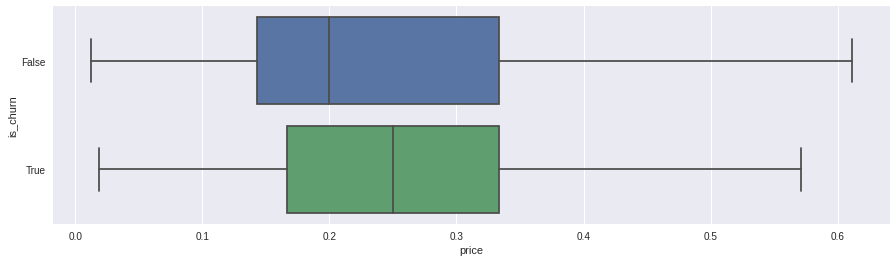

In [ ]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar[auxiliar.price > 0], x='price', y='is_churn', orient='h', showfliers=False)
plt.show()

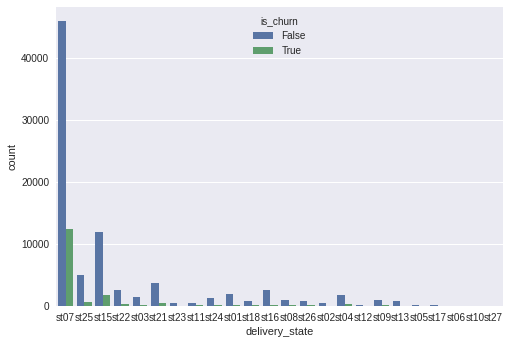

In [ ]:
sns.countplot(data=train_merged, x='delivery_state', hue='is_churn')
plt.show()

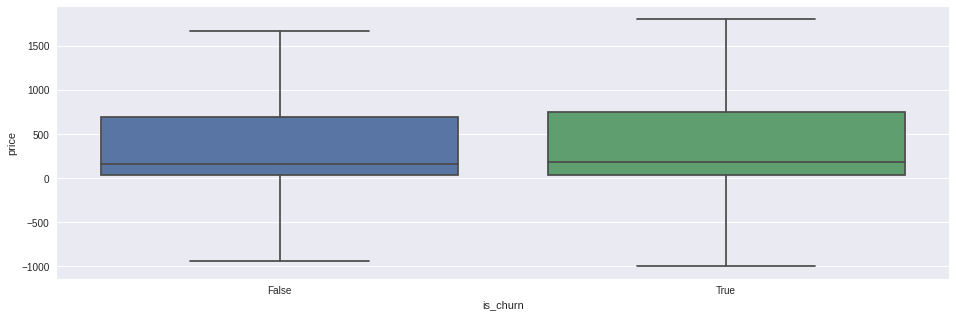

In [ ]:
plt.figure(figsize=(16,5))
sns.boxplot(data=train_merged, y='price', x='is_churn', showfliers=False)
plt.show()

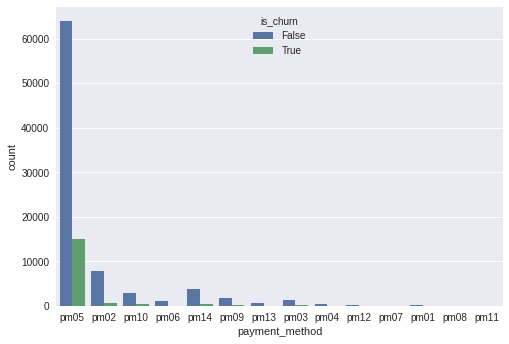

In [ ]:
sns.countplot(data=train_merged, x='payment_method', hue='is_churn')
plt.show()

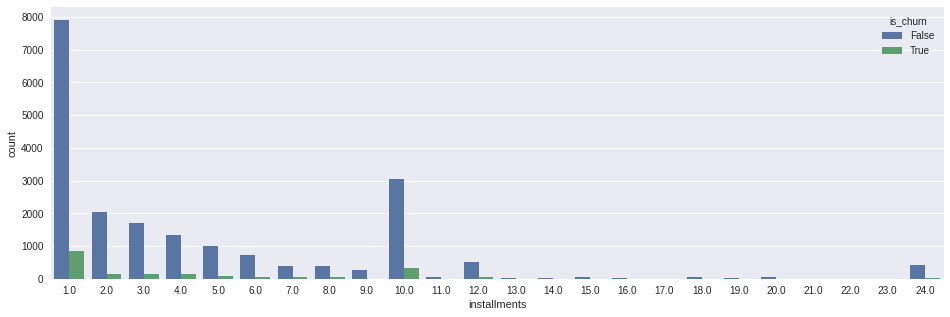

In [ ]:
plt.figure(figsize=(16,5))
sns.countplot(data=train_merged, x='installments', hue='is_churn')
plt.show()

In [ ]:
auxiliar = pd.merge(train_merged.groupby('client_id')[['installments']].mean().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id')

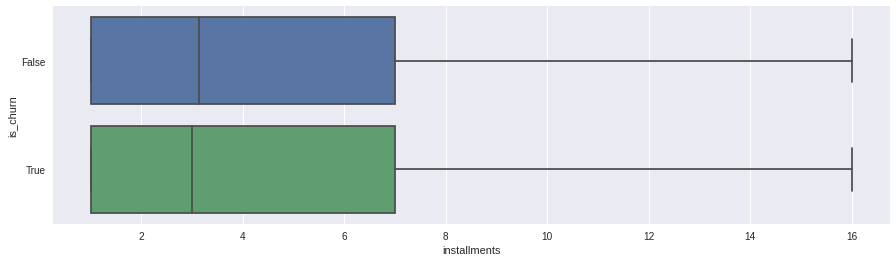

In [ ]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='installments', y='is_churn', orient='h', showfliers=False)
plt.show()

In [ ]:
auxiliar = train_merged.copy()
auxiliar['installments'].fillna(0, inplace=True)

In [ ]:
auxiliar = pd.merge(auxiliar.groupby('client_id')[['installments']].mean().reset_index(),
                    clients_train[['client_id', 'is_churn']], on='client_id') 

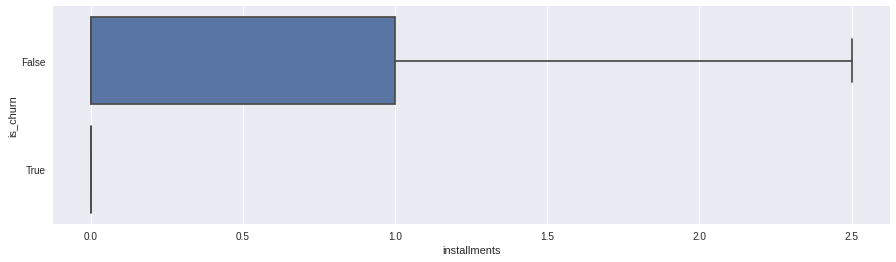

In [ ]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=auxiliar, x='installments', y='is_churn', orient='h', showfliers=False)
plt.show()

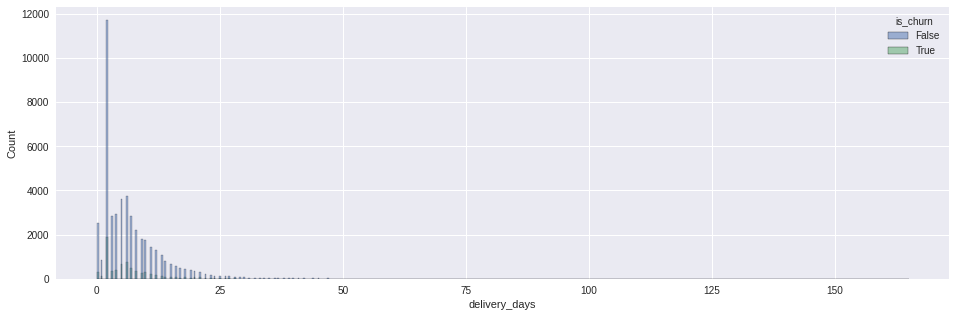

In [ ]:
plt.figure(figsize=(16,5))
sns.histplot(data=train_merged, x='delivery_days', hue='is_churn')
plt.show()

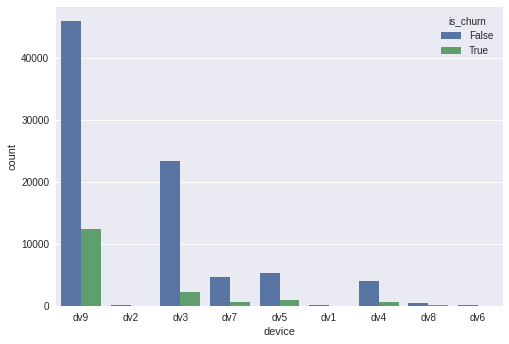

In [ ]:
sns.countplot(data=train_merged, x='device', hue='is_churn')
plt.show()

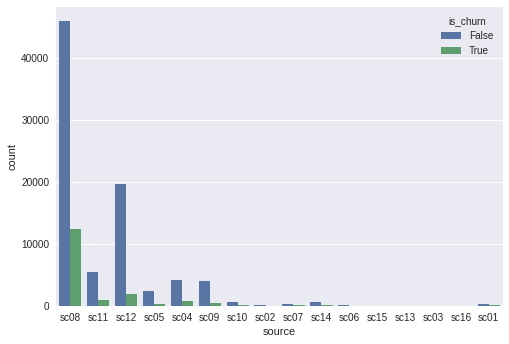

In [ ]:
sns.countplot(data=train_merged, x='source', hue='is_churn')
plt.show()

### Pré-processamento:

Transformaremos o birthday ao formato datetime;

Preencheremos os dados faltantantes com 0, conforme teorias anteriores;

Será criada uma nova feature, negative, que será utilizada na feature engineering. Ela representa a quantidade de unidades identificadas com um valor negativo;

Não será removida nenhuma feature, para que seja realizada uma análise de importância das features desenvolvidas na próxima etapa.

In [ ]:
orders['datetime'] = pd.to_datetime(orders['datetime'])
clients_train['birthdate'] = pd.to_datetime(clients_train['birthdate'])
clients_test['birthdate'] = pd.to_datetime(clients_test['birthdate'])
clients_challenge['birthdate'] = pd.to_datetime(clients_challenge['birthdate'])
orders['installments'].fillna(0, inplace=True)
orders['delivery_days'].fillna(0, inplace=True)
orders['negative'] = orders.apply(lambda row: 1*row['units'] if row['price']<0 else 0, axis=1)

### Feature Engeneering:

A feature enginering terá como objetivo agrupar os dados por cliente, realizando uma contagem de diferentes tipos de categorias dentro dos grupos e uma extração da média, desvio padrão, valores mínimos, máximos e quartis das variáveis numéricas. A data de nascimento será convertida em idade. Ainda, será feita uma soma do total de unidades, total de volume de gastos e total de unidades com ordens negativas.

gender_g1: bool calculada a partir do gender;

client_age: calculada a partir do birthdate;

sum_units: total de itens comprados em 2019;

sum_volume: total gasto em compras em 2019;

sum_negative: total de unidades com transações negativas em compras em 2019;

count_orders_states_ne: quantidade de compras entregando em estados diferentes ao do cliente;

count_orders_states_eq: quantidade de compras entregando em estados iguais ao do cliente;

count_product_id: quantidade de produtos diferentes presentes nas compras;

count_device: quantidade de devices diferentes utilizados nas compras;

count_source: quantidade de canais diferentes que geraram o lead;

count_payment_method: quantidade de meios de pagamento em compras;

count_category_lv0: quantidade de categorias diferentes (nível 0) em compras;

count_category_lv1: quantidade de categorias diferentes (nível 1) em compras;

count_category_lv2: quantidade de categorias diferentes (nível 2) em compras;

count_category_lv3: quantidade de categorias diferentes (nível 3) em compras;

count_category_lv4: quantidade de categorias diferentes (nível 4) em compras;

price_avg: média dos preços pagos em cada item comprado;

price_std: desvio padrão dos preços pagos em cada item comprado;

price_min: mínimo dos preços pagos em cada item comprado;

price_25p: quartil 25% dos preços pagos em cada item comprado;

price_50p: quartil 50% dos preços pagos em cada item comprado;

price_75p: quartil 75% dos preços pagos em cada item comprado;

price_max: máximo dos preços pagos em cada item comprado;

delivery_days_avg: média da quantidade de dias para entregar (prazo);

delivery_days_std: desvio padrão da quantidade de dias para entregar (prazo);

delivery_days_min: mínimo da quantidade de dias para entregar (prazo);

delivery_days_25p: quartil 25% da quantidade de dias para entregar (prazo);

delivery_days_50p: quartil 50% da quantidade de dias para entregar (prazo);

delivery_days_75p: quartil 75% da quantidade de dias para entregar (prazo);

delivery_days_max: máximo da quantidade de dias para entregar (prazo);

installments_avg: média da quantidade de parcelas de pagamento;

installments_std: desvio padrão da quantidade de parcelas de pagamento;

installments_min: mínimo da quantidade de parcelas de pagamento;

installments_25p: quartil 25% da quantidade de parcelas de pagamento;

installments_50p: quartil 50% da quantidade de parcelas de pagamento;

installments_75p: quartil 75% da quantidade de parcelas de pagamento;

installments_max: máximo da quantidade de parcelas de pagamento.

In [ ]:
clients_train.set_index('client_id', inplace=True)
clients_test.set_index('client_id', inplace=True)
clients_challenge.set_index('client_id', inplace=True)
orders.set_index('order_id', inplace=True)
product.set_index('product_id', inplace=True)

In [ ]:
class OrderAggregatorFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe base para FeaturesTransformers que usam os dados de Histórico de Vendas para extrair os dados.
    """
    
    def __init__(self, orders_table, columns=None, product_table=None, imputer=None):
        
        self.work_table = None
        if product_table is not None:
            self.refr_table = pd.merge(
                orders_table,
                product_table.reset_index(),
                on='product_id'
            )
        else:
            self.refr_table = orders_table.copy()
        if columns is not None:
            self.refr_table = self.refr_table[['client_id', *columns]]
        self._reset_database()
        self.imputer = imputer
        self.columns = columns

    def _reset_database(self):
        self.work_table = self.refr_table.copy()
        return self

    def _process_client(self, df):
        return df.set_index('client_id')

    def _select_orders(self, df):
        idx = self.work_table['client_id'].isin(df.index)
        return self.work_table[idx]

    def fit(self, X, y=None, **fit_params):
        if self.imputer is not None:
            self._reset_database()
            self.imputer.fit(self._select_orders(X)[self.columns])
            self.work_table.loc[:, self.columns] = self.imputer.transform(self.work_table[self.columns])
        return self
    
    def transform(self, X):
        return self._select_orders(X).groupby('client_id').apply(self._process_client)

In [ ]:
class UniqueCounterTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.apply(lambda x: len(x.unique())).rename(index=lambda x: f'count_{x}')

In [ ]:
class SumValuesTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.sum().rename(index=lambda x: f'sum_{x}')

In [ ]:
class DistributionTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = (super()
               ._process_client(df)
               .describe()
               .drop(index='count')
               .rename(index=lambda c: c.replace('%', 'p')) 
               .rename(index={'mean': 'avg'})
               .unstack())
        tmp.index = tmp.index.map('_'.join)
        return tmp

In [ ]:
class CountStateMatchesTransform(OrderAggregatorFeaturesTransform):
    
    def _process_client(self, df):
        tmp = df.set_index('client_id')[['state', 'delivery_state']]
        return pd.Series({
            'count_orders_states_eq': (tmp.state == tmp.delivery_state).sum(),
            'count_orders_states_ne': (tmp.state != tmp.delivery_state).sum()
        })

    def transform(self, X):
        return (
            pd.merge(
                self._select_orders(X),
                X[['state']].reset_index(),
                on='client_id'
            ).groupby('client_id').apply(self._process_client)
        )

In [ ]:
class FeatureEngineeringTransform(BaseEstimator, TransformerMixin):

    def __init__(self, orders_table, product_table):
        orders_table['volume'] = orders_table.units * orders_table.price
        self._transf_sum = SumValuesTransform(orders_table=orders_table, columns=['units', 'volume', 'negative'])
        self._transf_stt = CountStateMatchesTransform(orders_table=orders_table[['client_id', 'delivery_state']])
        self._transf_cnt = UniqueCounterTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['product_id', 'device', 'source', 'payment_method', 
                     'category_lv0', 'category_lv1', 'category_lv2', 'category_lv3', 'category_lv4']
        )
        self._transf_dst_med = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['price', 'delivery_days'],
            imputer=SimpleImputer(strategy='median')
        )
        self._transf_dst_one = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['installments'],
            imputer=SimpleImputer(strategy='constant', fill_value=1)
        )
        
    def fit(self, X, y=None, **fit_params): 
        self._transf_dst_med.fit(X)
        self._transf_dst_one.fit(X)
        return self
    
    def transform(self, X):
        output = (X[['gender']] == 'cg1').rename(columns={'gender': 'gender_cg1'})
        output['client_age'] = 2022 - X.birthdate.dt.year
        output = output.join(self._transf_sum.transform(X))
        output = output.join(self._transf_stt.transform(X))
        output = output.join(self._transf_cnt.transform(X))
        output = output.join(self._transf_dst_med.transform(X))
        output = output.join(self._transf_dst_one.transform(X))
        output.fillna(0, inplace=True)
        
        return output

In [ ]:
%%time
feateng = FeatureEngineeringTransform(orders, product).fit(clients_train)

CPU times: user 1.05 s, sys: 76.2 ms, total: 1.13 s
Wall time: 1.14 s


In [ ]:
%%time
train_dataset = feateng.transform(clients_train)

CPU times: user 7min 25s, sys: 7.13 s, total: 7min 32s
Wall time: 7min 31s


In [ ]:
train_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,...,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max
client_id,,,,,,,,,,,,,,,,,,,,,
cx05072,False,50,2.00000,119.800000,0.00000,0,2,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx03836,True,56,8.00000,625.720000,1.00000,0,7,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx08472,True,68,3.00000,2832.920000,0.00000,0,3,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx12946,True,67,1.00000,69.900000,0.00000,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx19045,False,64,16.00000,794.840000,1.00000,1,14,14,2,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx05312,True,41,4.00000,1038.020000,0.00000,0,3,3,1,1,...,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cx02434,False,25,1.00000,1952.900000,0.00000,0,1,1,1,1,...,2.0,2.0,2.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0
cx16024,True,72,4.00000,1158.000000,0.00000,0,3,3,1,1,...,0.0,5.5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scale_cols = train_dataset.columns[1:]
scale_cols

Index(['client_age', 'sum_units', 'sum_volume', 'sum_negative',
       'count_orders_states_eq', 'count_orders_states_ne', 'count_product_id',
       'count_device', 'count_source', 'count_payment_method',
       'count_category_lv0', 'count_category_lv1', 'count_category_lv2',
       'count_category_lv3', 'count_category_lv4', 'price_avg', 'price_std',
       'price_min', 'price_25p', 'price_50p', 'price_75p', 'price_max',
       'delivery_days_avg', 'delivery_days_std', 'delivery_days_min',
       'delivery_days_25p', 'delivery_days_50p', 'delivery_days_75p',
       'delivery_days_max', 'installments_avg', 'installments_std',
       'installments_min', 'installments_25p', 'installments_50p',
       'installments_75p', 'installments_max'],
      dtype='object')

In [ ]:
scaler = StandardScaler().fit(train_dataset[scale_cols])
scaler

StandardScaler()

In [ ]:
train_dataset.loc[:, scale_cols] = scaler.transform(train_dataset.loc[:, scale_cols])

In [ ]:
train_dataset = pd.merge(train_dataset, clients_train[['is_churn']], left_index=True, right_index=True)

In [ ]:
train_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,...,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max,is_churn
client_id,,,,,,,,,,,,,,,,,,,,,
cx05072,False,0.347788,-0.294982,-0.654008,-0.297865,-0.480636,-0.159651,-0.483604,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx03836,True,0.785662,0.236881,-0.487896,1.066705,-0.480636,1.185909,0.591497,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx08472,True,1.661411,-0.206338,0.236808,-0.297865,-0.480636,0.109461,-0.483604,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx12946,True,1.588432,-0.383625,-0.670392,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx19045,False,1.369494,0.946031,-0.432368,1.066705,-0.204918,3.069692,2.741699,1.107626,1.068076,...,-0.751254,-0.682934,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx05312,True,-0.309024,-0.117694,-0.352523,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,...,-0.236448,-0.065866,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False
cx02434,False,-1.476688,-0.383625,-0.052135,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.408050,-0.559520,4.079241,-0.444198,5.893317,5.147472,4.099024,3.017040,1.87191,False
cx16024,True,1.953327,-0.117694,-0.313129,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,...,0.192557,0.551202,-0.446097,-0.444198,-0.219480,-0.291641,-0.352737,-0.435843,-0.50370,False


In [ ]:
%%time
test_dataset = feateng.transform(clients_test)

CPU times: user 2min 23s, sys: 2.24 s, total: 2min 25s
Wall time: 2min 22s


In [ ]:
test_dataset.loc[:, scale_cols] = scaler.transform(test_dataset.loc[:, scale_cols])

In [ ]:
test_dataset = pd.merge(test_dataset, clients_test[['is_churn']], left_index=True, right_index=True)

In [ ]:
test_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,...,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max,is_churn
client_id,,,,,,,,,,,,,,,,,,,,,
cx06840,True,-0.382003,0.325525,-0.557937,-0.297865,-0.480636,1.185909,0.860272,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx01931,True,-0.163065,-0.117694,-0.617956,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx35431,True,0.858641,-0.383625,-0.667404,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx36233,False,1.661411,-0.294982,0.831122,-0.297865,-0.480636,-0.159651,-0.483604,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx13540,True,0.858641,-0.117694,-0.632994,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx19119,True,-0.236045,-0.383625,-0.431002,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx21963,False,-0.527961,-0.383625,-0.680537,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False
cx37195,False,1.223536,-0.383625,-0.657163,-0.297865,-0.480636,-0.428763,-0.752379,-0.541915,-0.538487,...,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.50370,False


In [ ]:
%%time
challenge_dataset = feateng.transform(clients_challenge)

CPU times: user 2min 25s, sys: 2.12 s, total: 2min 27s
Wall time: 2min 24s


In [ ]:
challenge_dataset.loc[:, scale_cols] = scaler.transform(challenge_dataset.loc[:, scale_cols])

In [ ]:
challenge_dataset

,gender_cg1,client_age,sum_units,sum_volume,sum_negative,count_orders_states_eq,count_orders_states_ne,count_product_id,count_device,count_source,...,delivery_days_50p,delivery_days_75p,delivery_days_max,installments_avg,installments_std,installments_min,installments_25p,installments_50p,installments_75p,installments_max
client_id,,,,,,,,,,,,,,,,,,,,,
cx12525,True,3.266949,-0.029050,-0.569202,-0.297865,-0.480636,0.647685,0.322722,-0.541915,-0.538487,...,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx32280,True,-0.454982,-0.029050,-0.386279,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,...,-0.650624,-0.408050,0.180961,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx00471,False,0.931620,0.414168,-0.257017,1.066705,-0.480636,1.455021,0.591497,-0.541915,-0.538487,...,-0.130782,0.106756,-0.189280,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx18876,False,0.420767,0.414168,2.153355,-0.297865,-0.480636,1.993244,1.129048,-0.541915,-0.538487,...,-0.650624,-0.107747,-0.189280,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx38255,True,1.369494,-0.206338,0.012022,-0.297865,-0.480636,0.109461,-0.214829,-0.541915,-0.538487,...,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx37820,True,-0.236045,-0.117694,-0.571004,-0.297865,0.346518,-0.697875,-0.214829,-0.541915,-0.538487,...,0.804934,0.449960,0.057547,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx00770,False,0.931620,0.059593,-0.474868,-0.297865,-0.480636,0.378573,0.053947,-0.541915,-0.538487,...,-0.650624,-0.751254,-0.806348,-0.446097,-0.444198,-0.21948,-0.291641,-0.352737,-0.435843,-0.503700
cx01686,False,0.347788,0.059593,-0.499174,-0.297865,0.346518,-0.428763,-0.214829,1.107626,1.068076,...,-0.442687,-0.536752,-0.559520,0.572104,0.640722,-0.21948,0.524226,0.537615,0.513700,0.684105


### Análise Exploratória Final:

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23292 entries, cx05072 to cx00861
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender_cg1              23292 non-null  bool   
 1   client_age              23292 non-null  float64
 2   sum_units               23292 non-null  float64
 3   sum_volume              23292 non-null  float64
 4   sum_negative            23292 non-null  float64
 5   count_orders_states_eq  23292 non-null  float64
 6   count_orders_states_ne  23292 non-null  float64
 7   count_product_id        23292 non-null  float64
 8   count_device            23292 non-null  float64
 9   count_source            23292 non-null  float64
 10  count_payment_method    23292 non-null  float64
 11  count_category_lv0      23292 non-null  float64
 12  count_category_lv1      23292 non-null  float64
 13  count_category_lv2      23292 non-null  float64
 14  count_category_lv3      23292 non-n

In [ ]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
client_age,23292.0,1.757138e-16,1.000021,-2.425416,-0.746898,-0.163065,0.712683,5.602279
sum_units,23292.0,2.165917e-17,1.000021,-0.383625,-0.294982,-0.206338,0.059593,82.852848
sum_volume,23292.0,1.098211e-17,1.000021,-4.379565,-0.538747,-0.240761,0.240016,59.021315
sum_negative,23292.0,-2.013387e-17,1.000021,-0.297865,-0.297865,-0.297865,-0.297865,40.639079
count_orders_states_eq,23292.0,0.000000e+00,1.000021,-0.480636,-0.480636,-0.480636,0.070800,25.988300
count_orders_states_ne,23292.0,-4.880939e-17,1.000021,-0.697875,-0.697875,-0.159651,0.378573,25.675092
count_product_id,23292.0,-2.196423e-17,1.000021,-0.752379,-0.483604,-0.214829,0.322722,21.018415
count_device,23292.0,-1.561901e-16,1.000021,-0.541915,-0.541915,-0.541915,1.107626,7.705792
count_source,23292.0,1.391068e-16,1.000021,-0.538487,-0.538487,-0.538487,1.068076,9.100891
count_payment_method,23292.0,6.345221e-17,1.000021,-0.543817,-0.543817,-0.543817,0.941825,8.370031


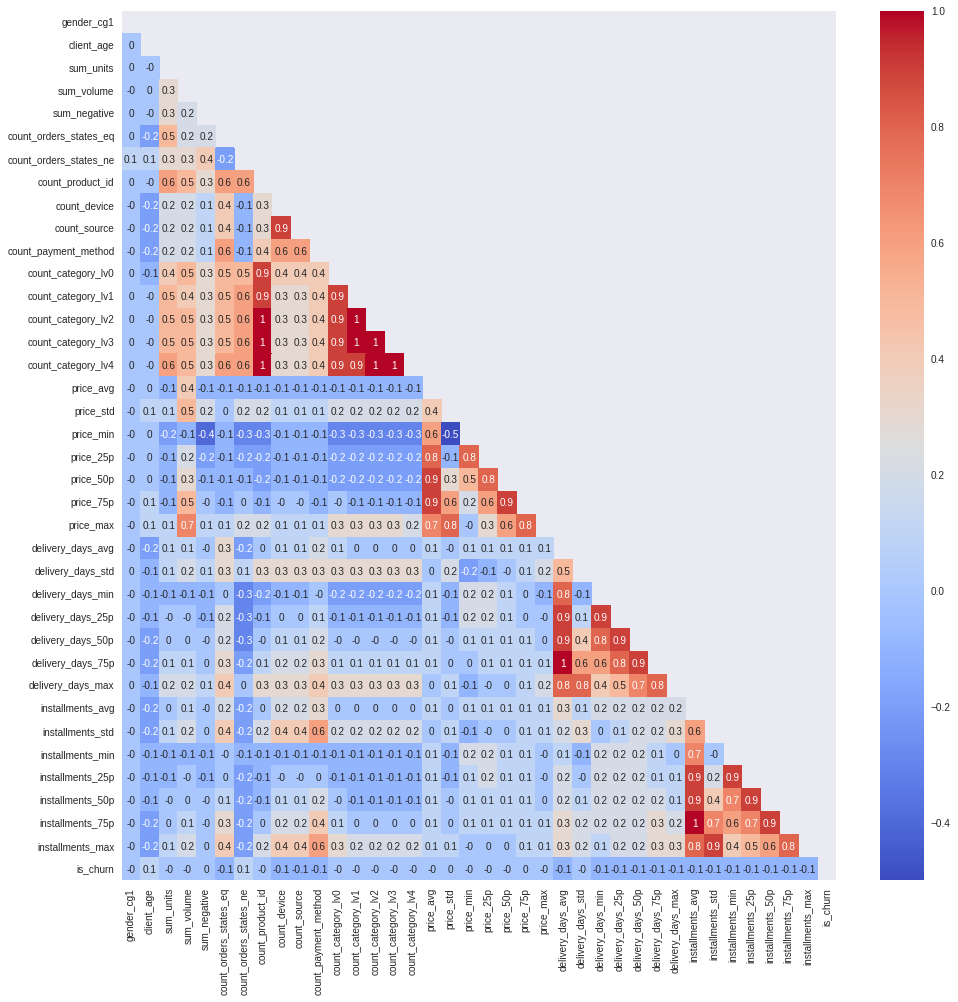

In [ ]:
plt.figure(figsize=(16,16))
mask = np.triu(np.ones_like(train_dataset.corr(), dtype=bool))

sns.heatmap(train_dataset.corr().round(1), annot=True, mask=mask, cmap='coolwarm')
plt.show()

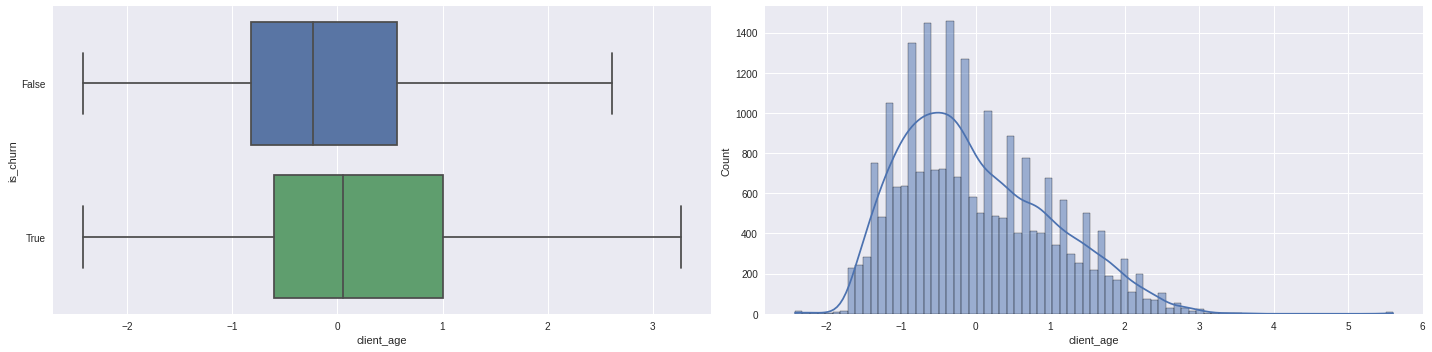

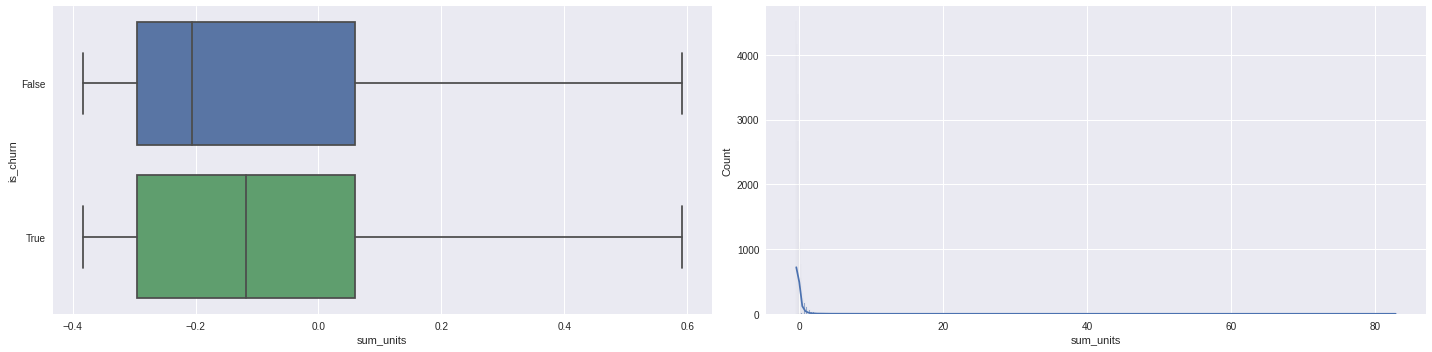

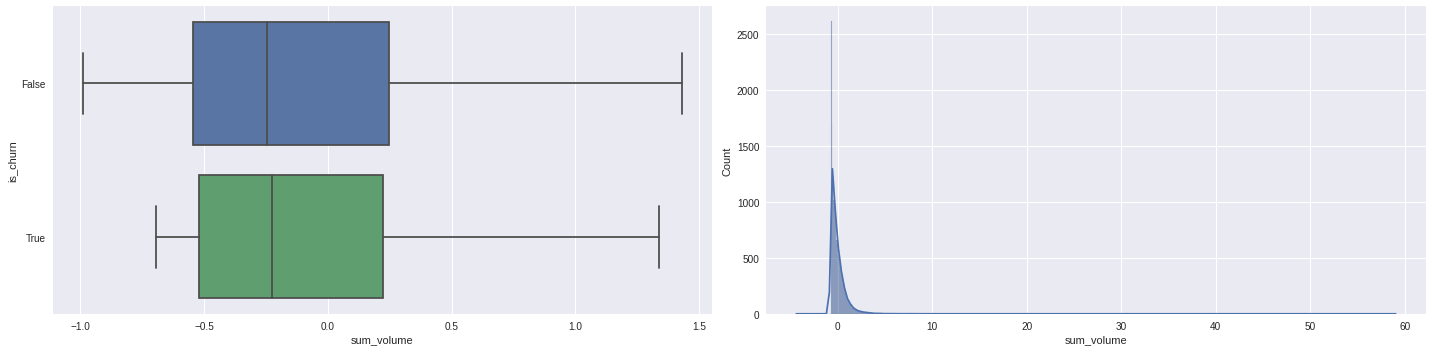

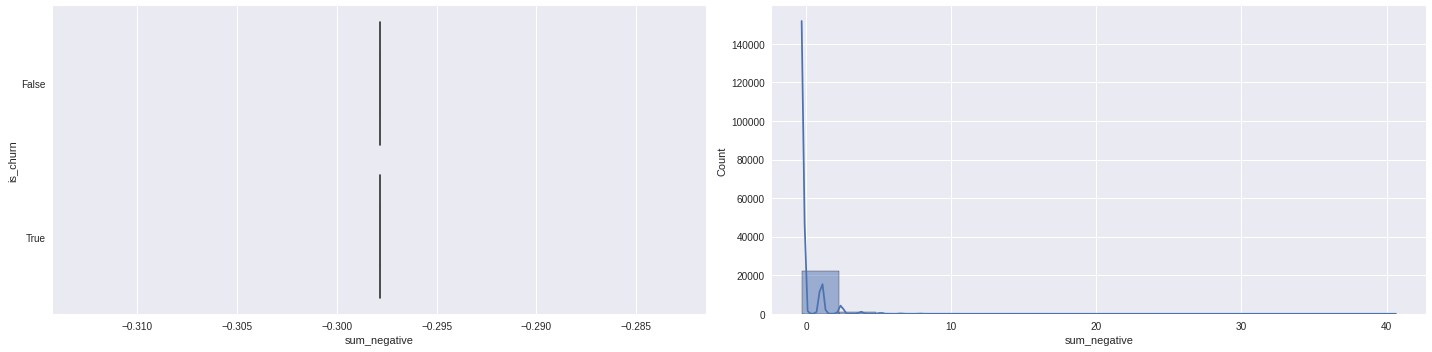

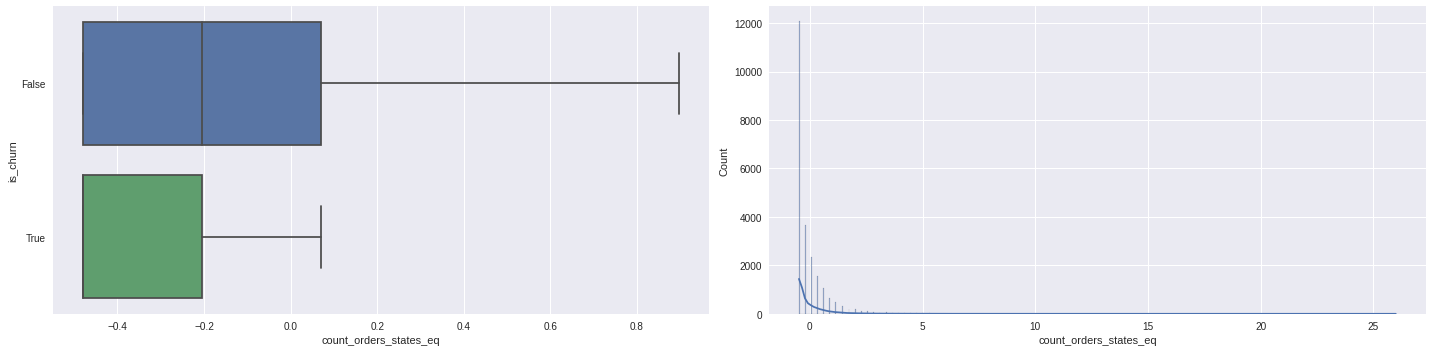

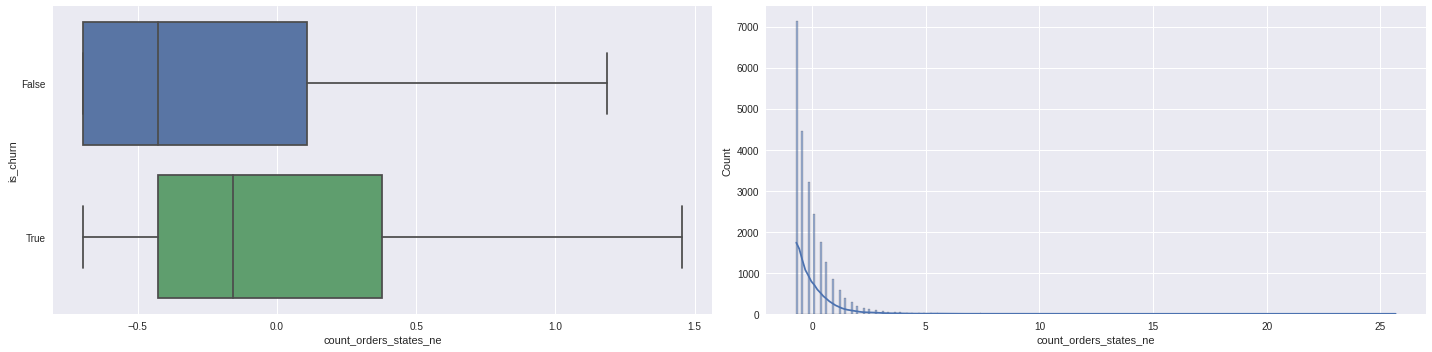

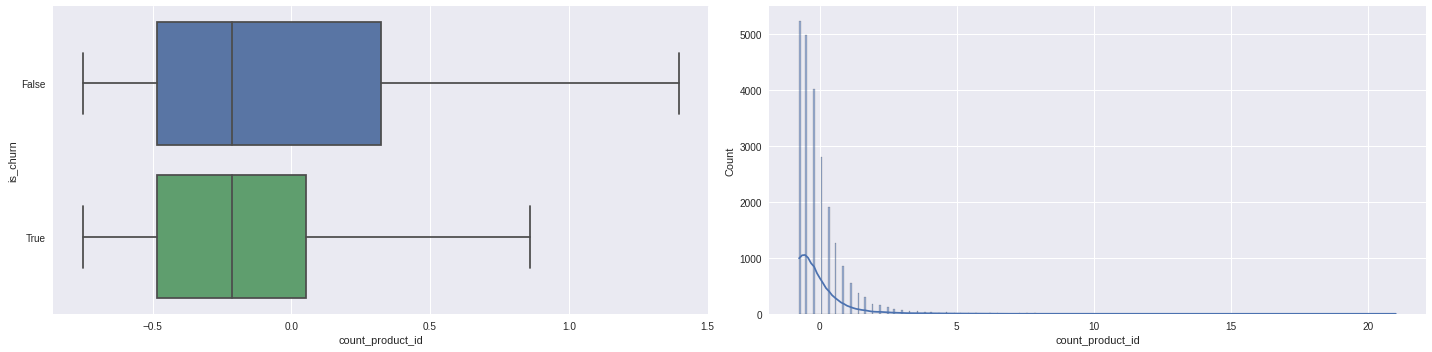

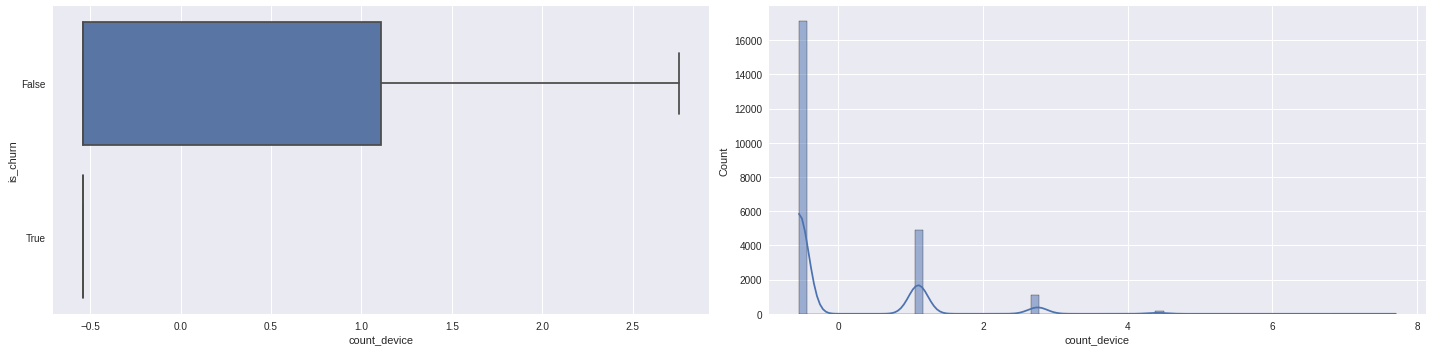

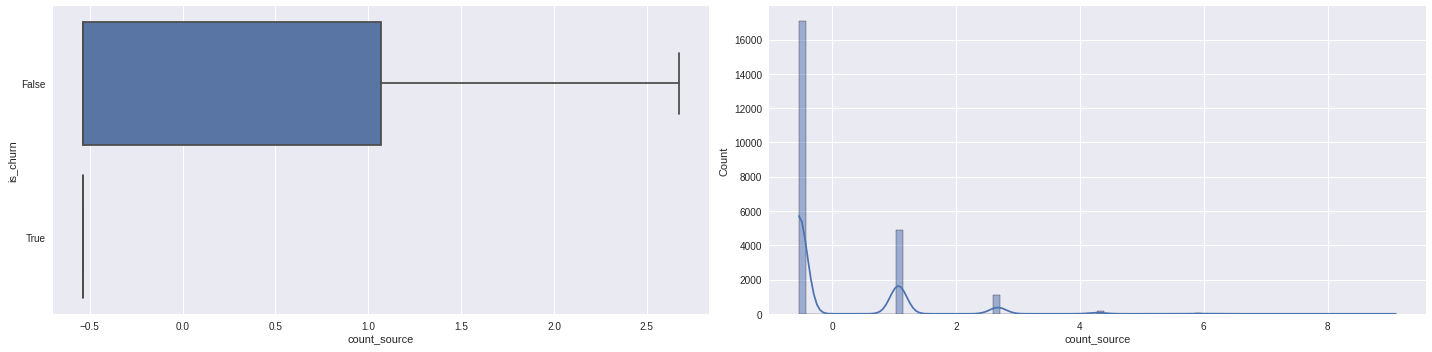

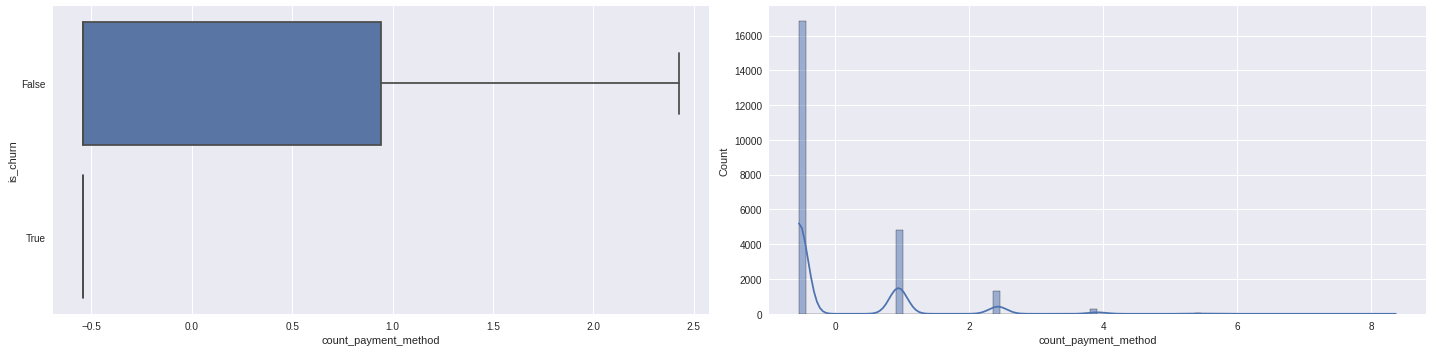

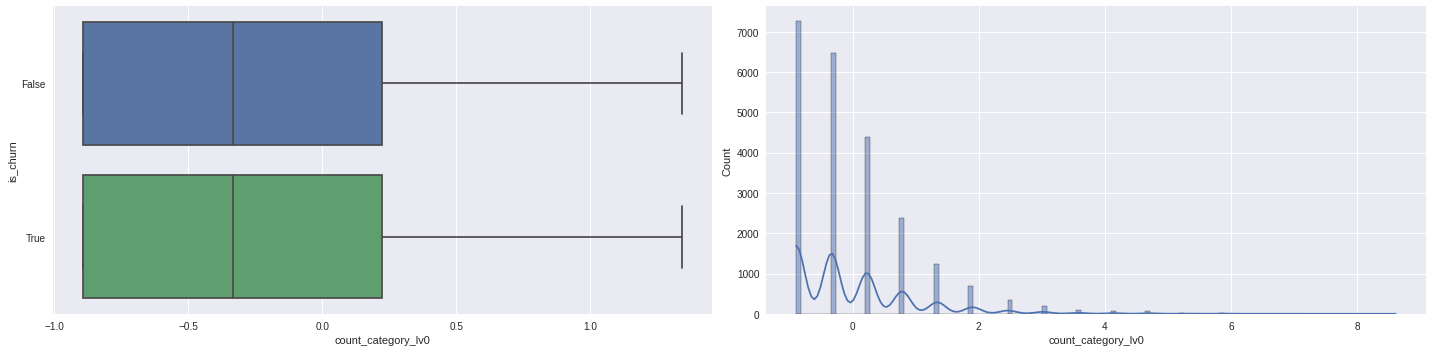

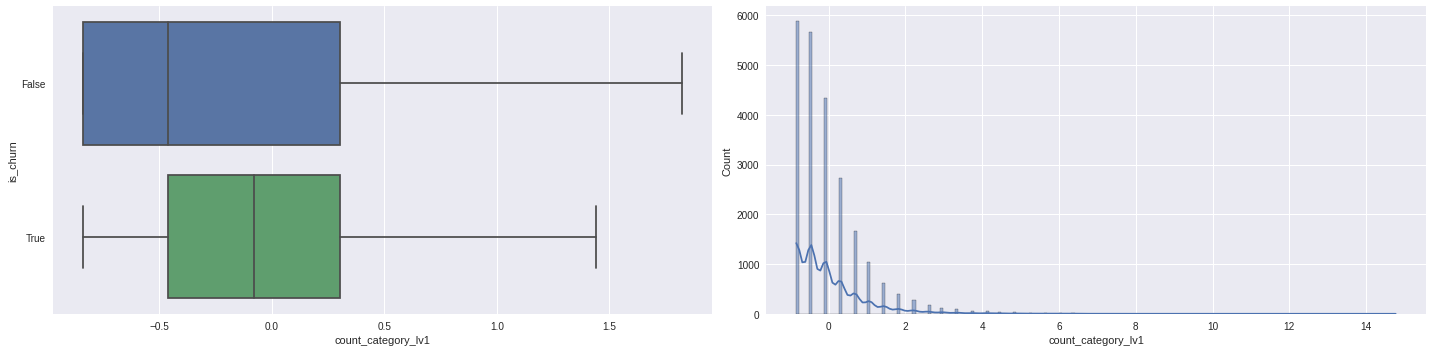

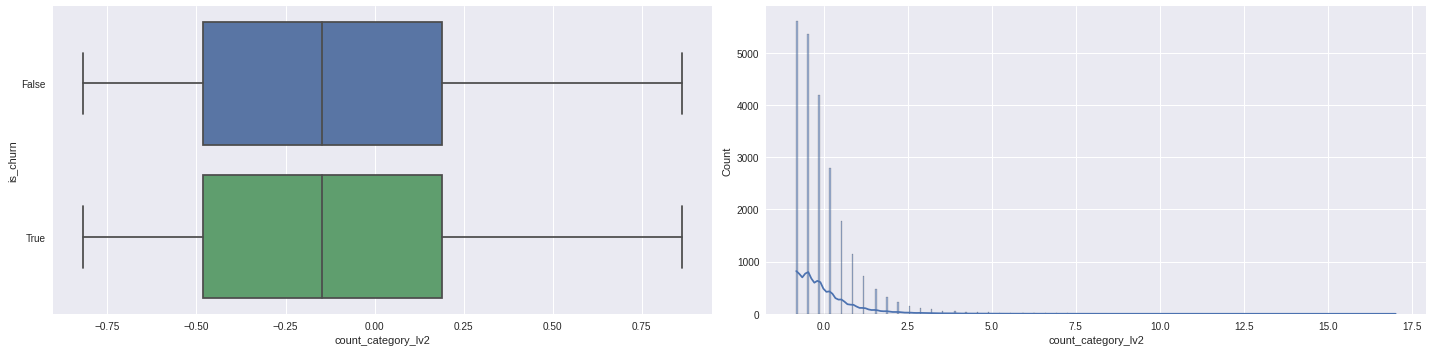

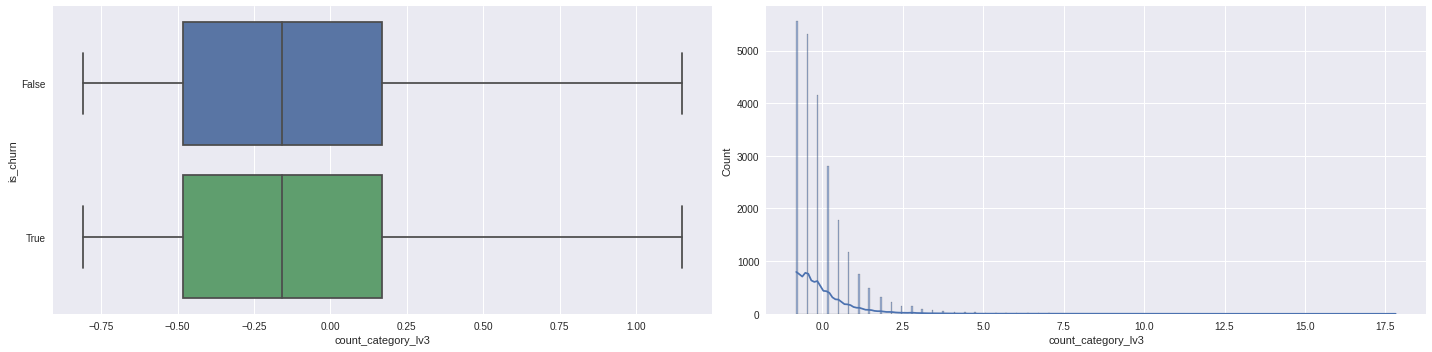

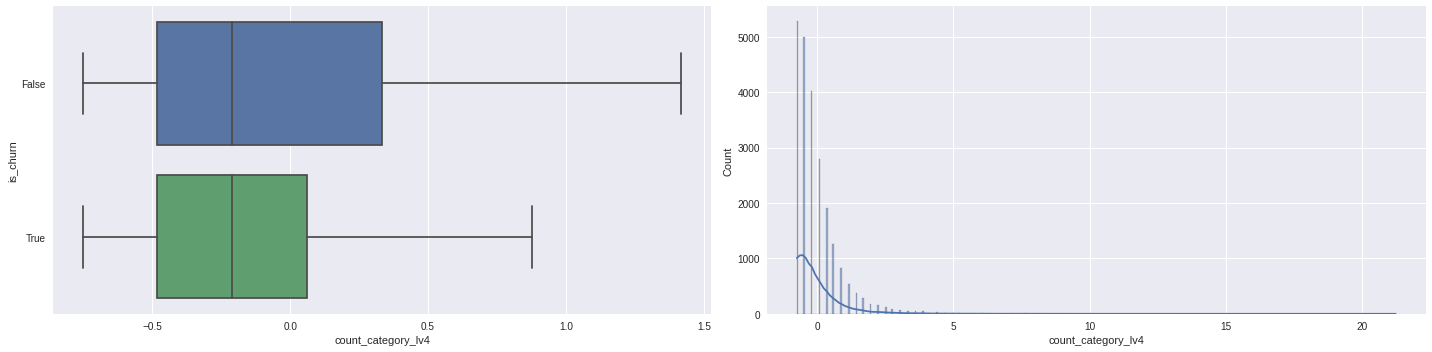

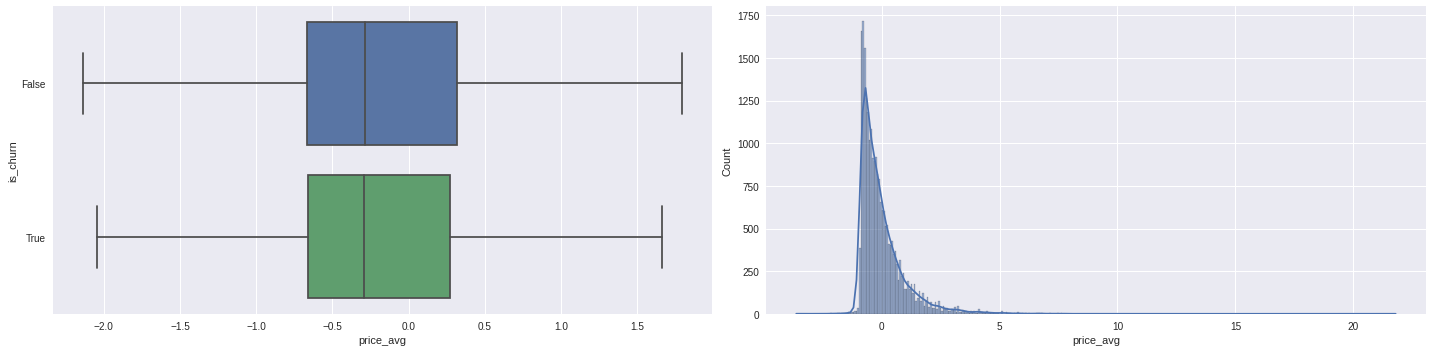

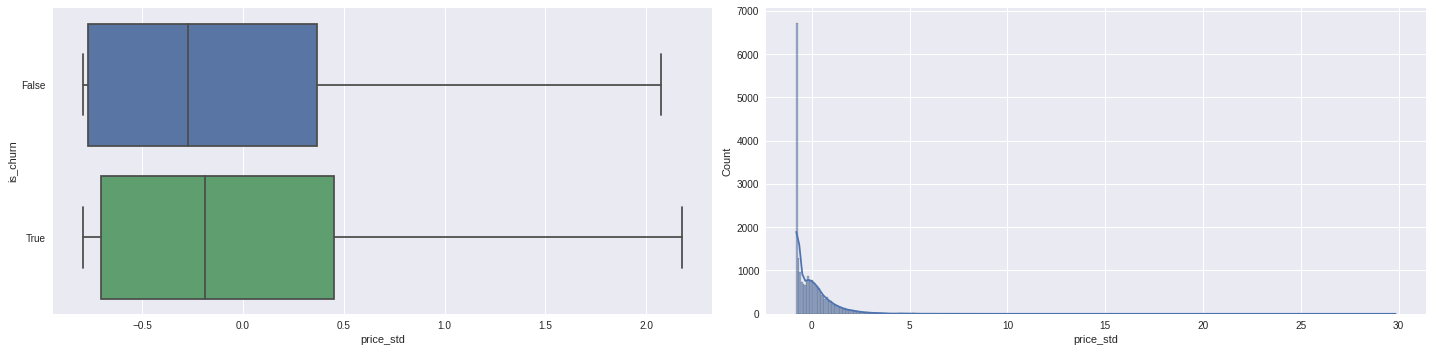

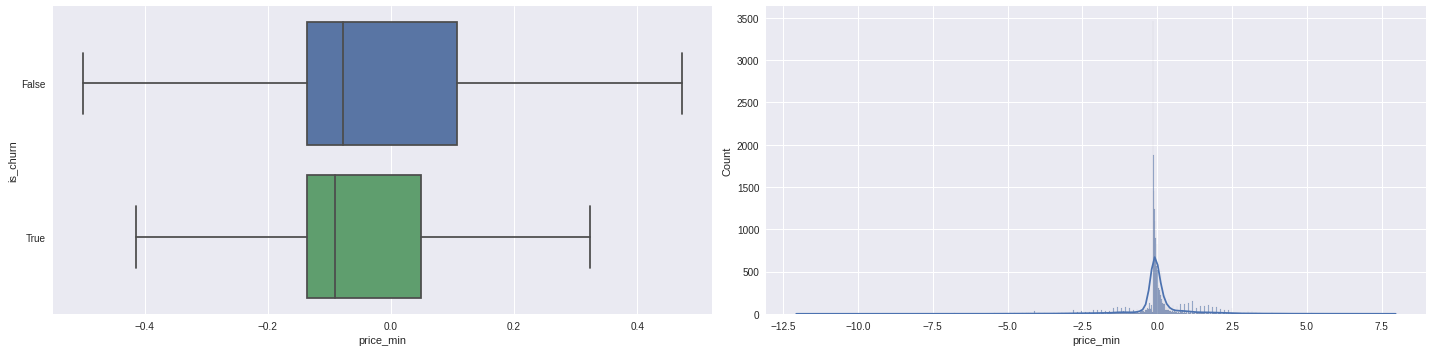

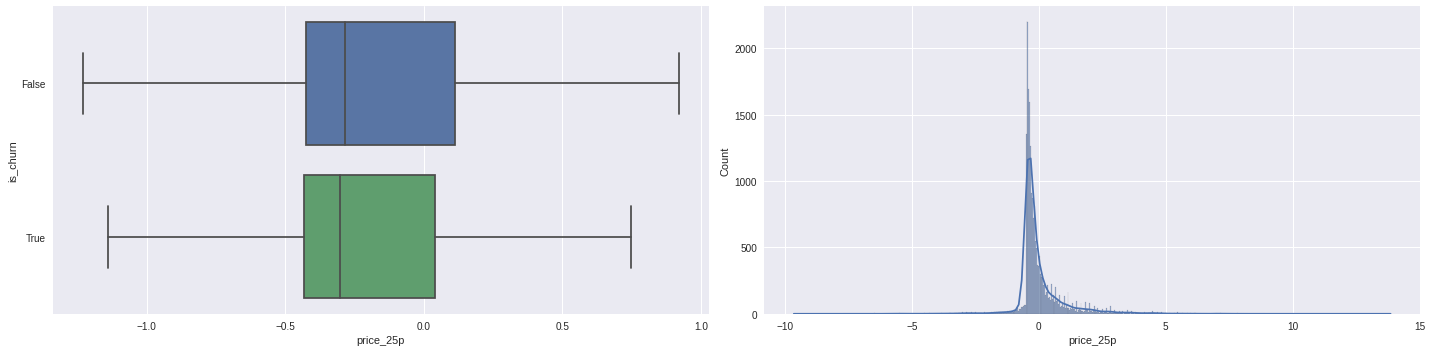

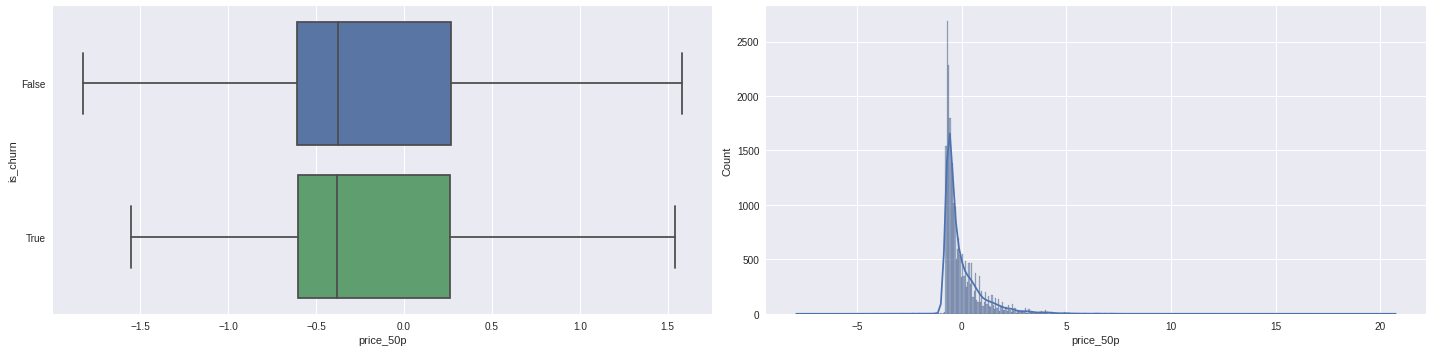

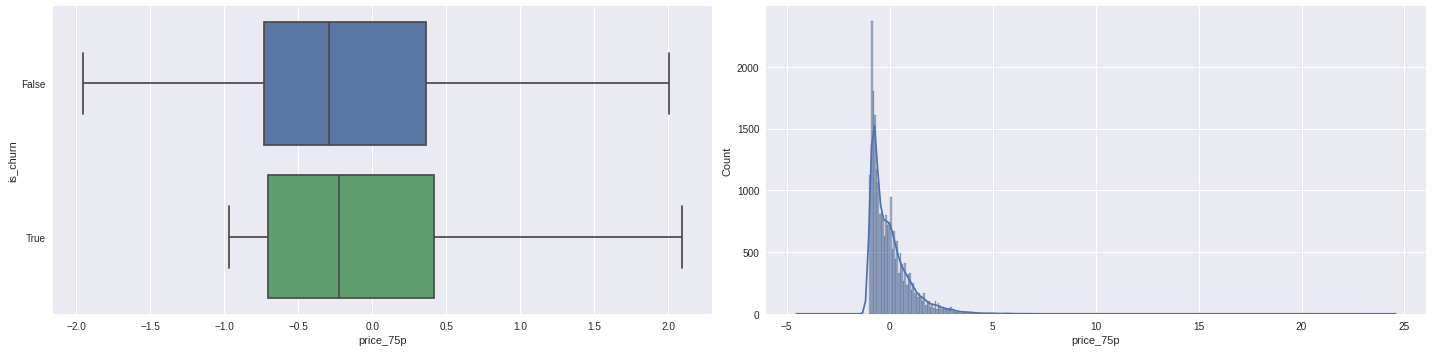

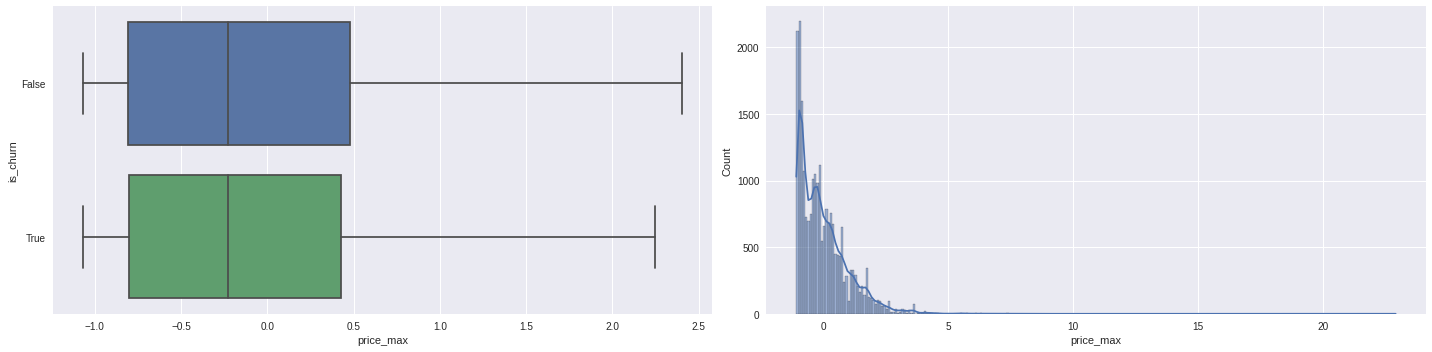

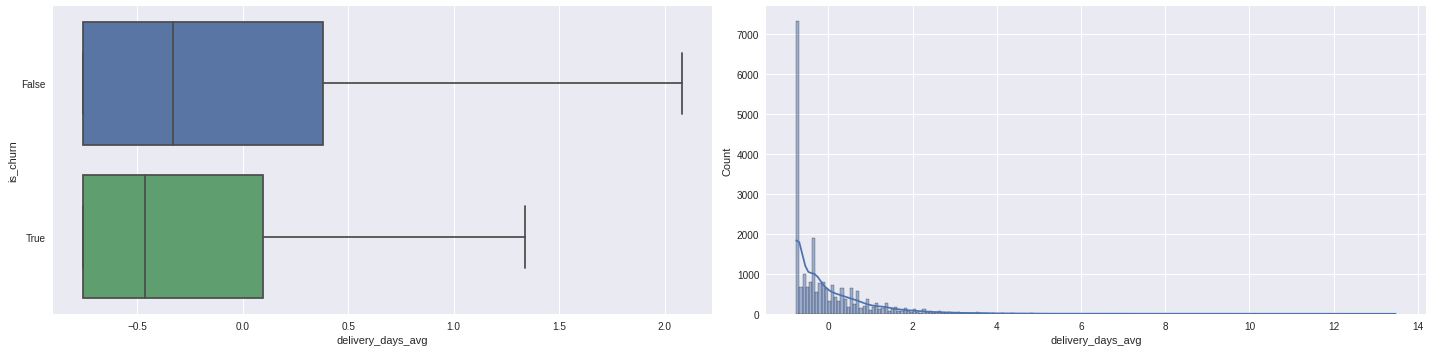

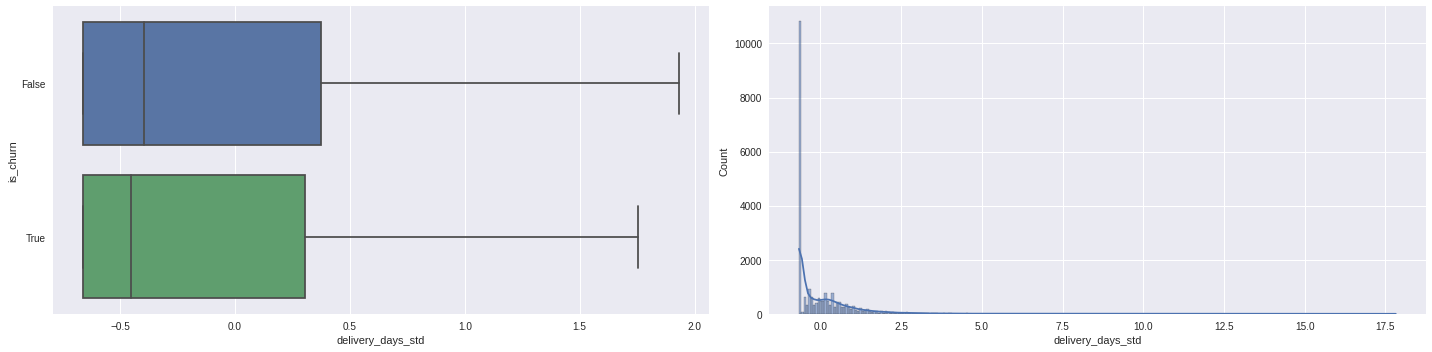

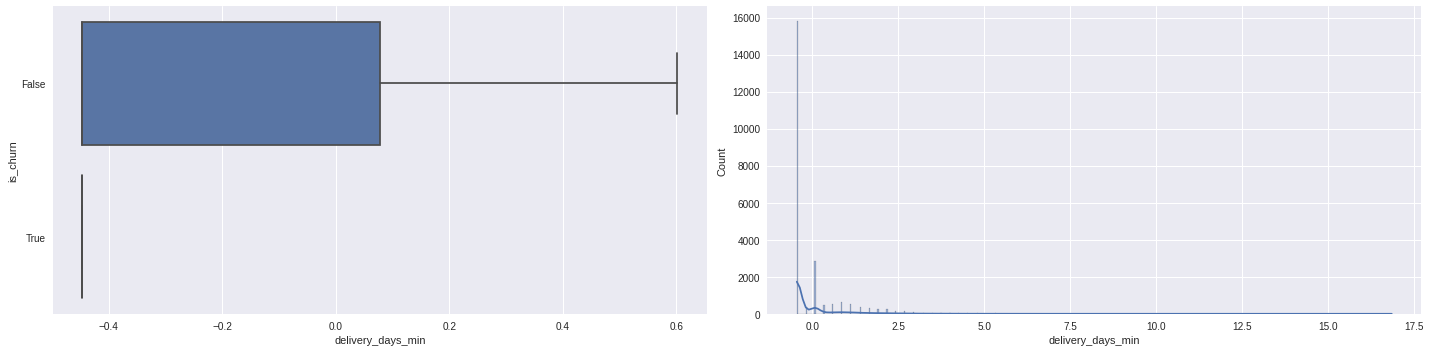

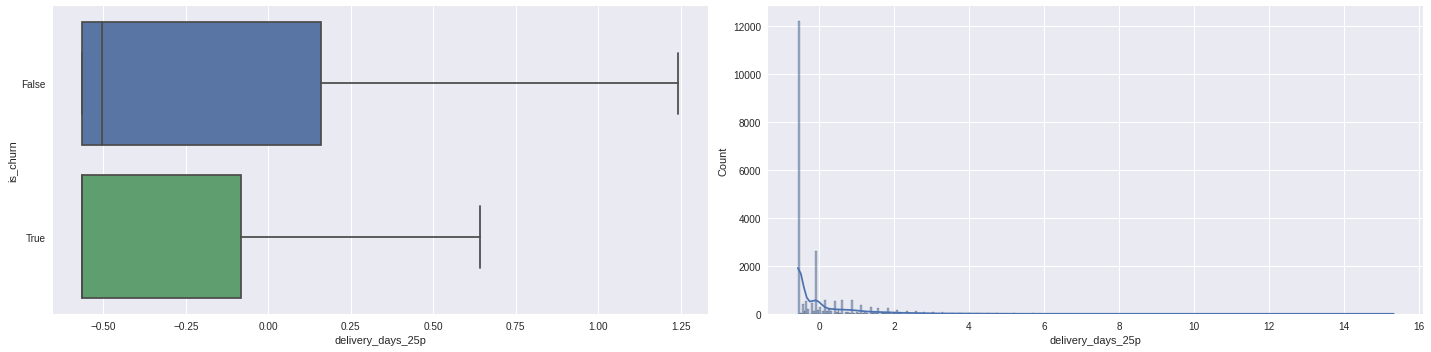

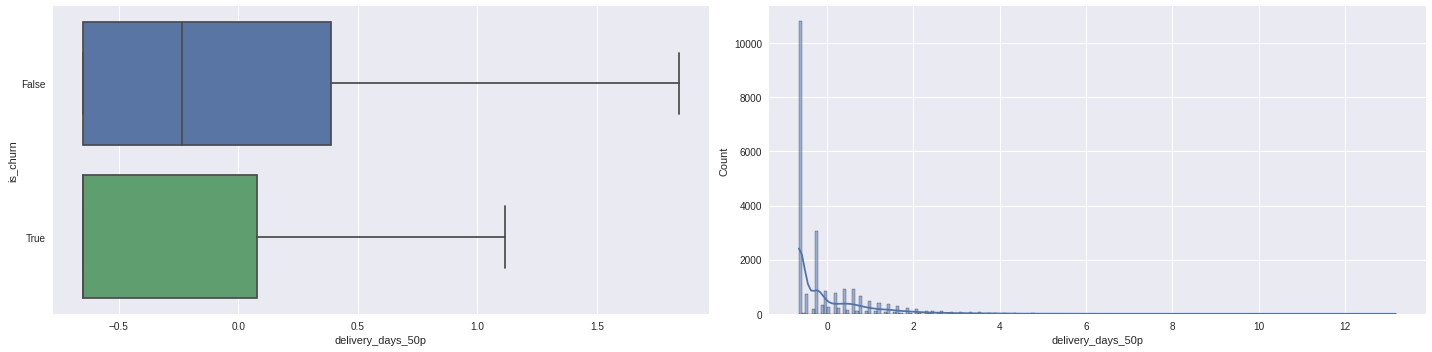

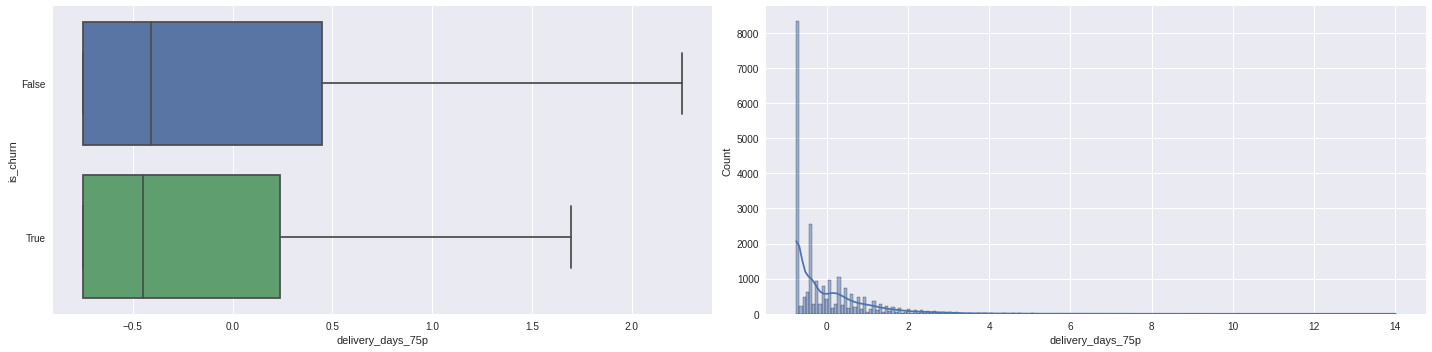

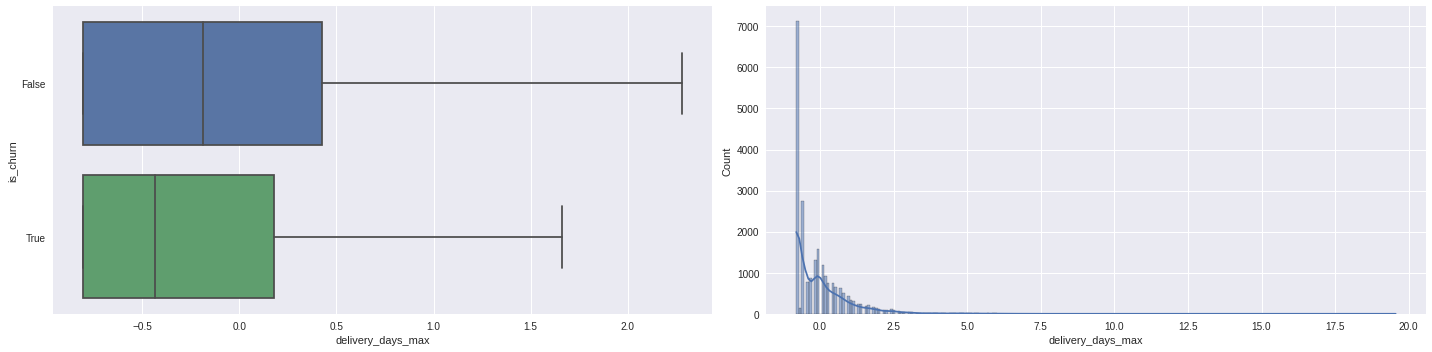

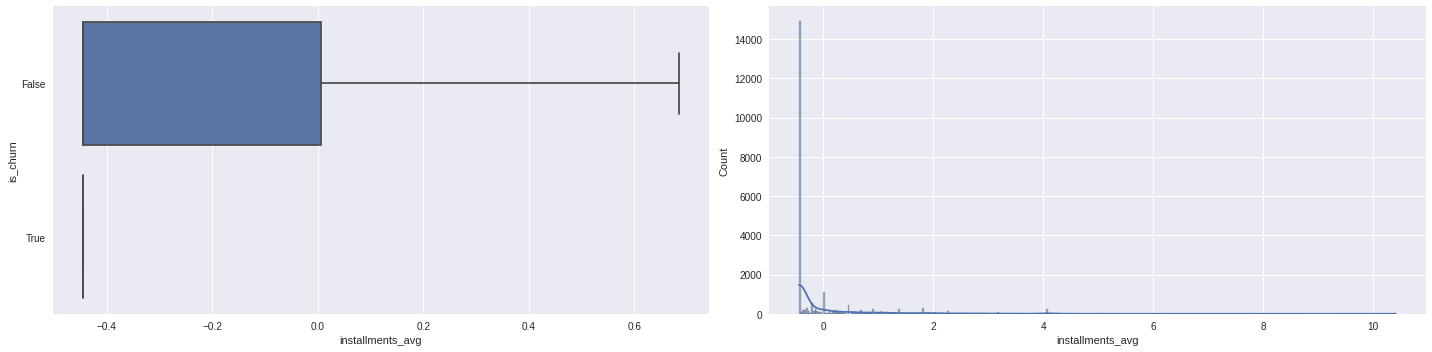

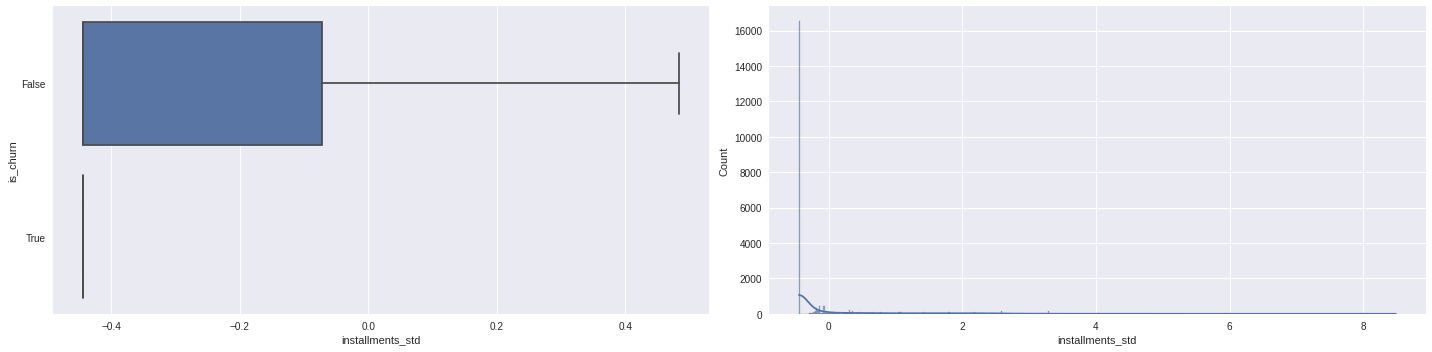

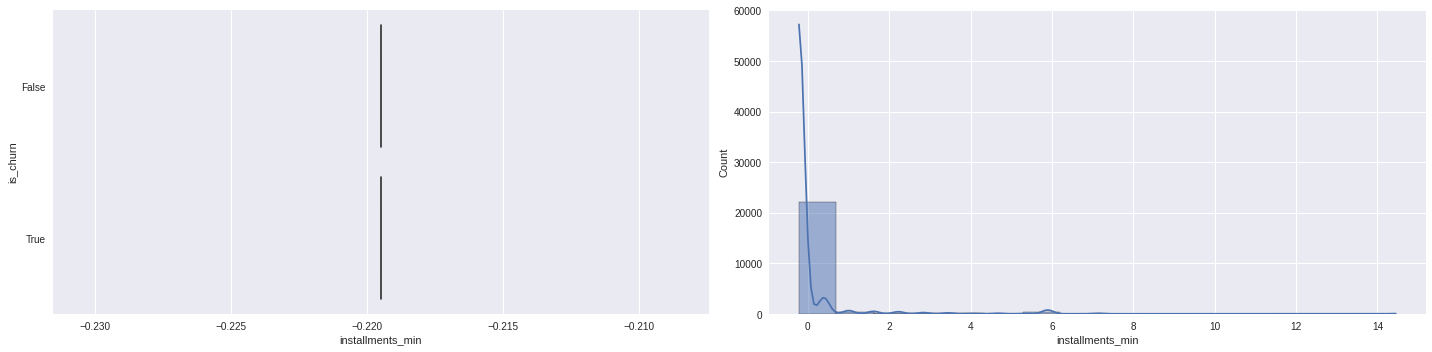

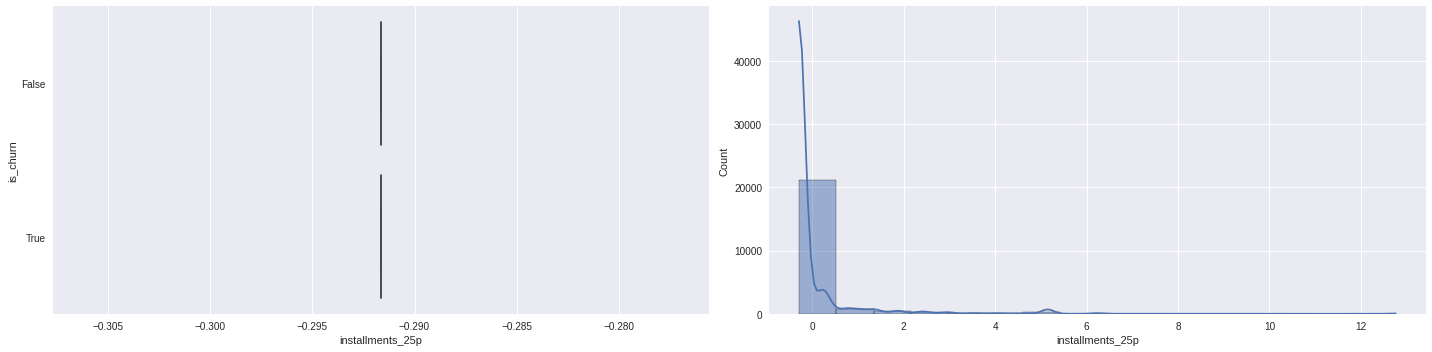

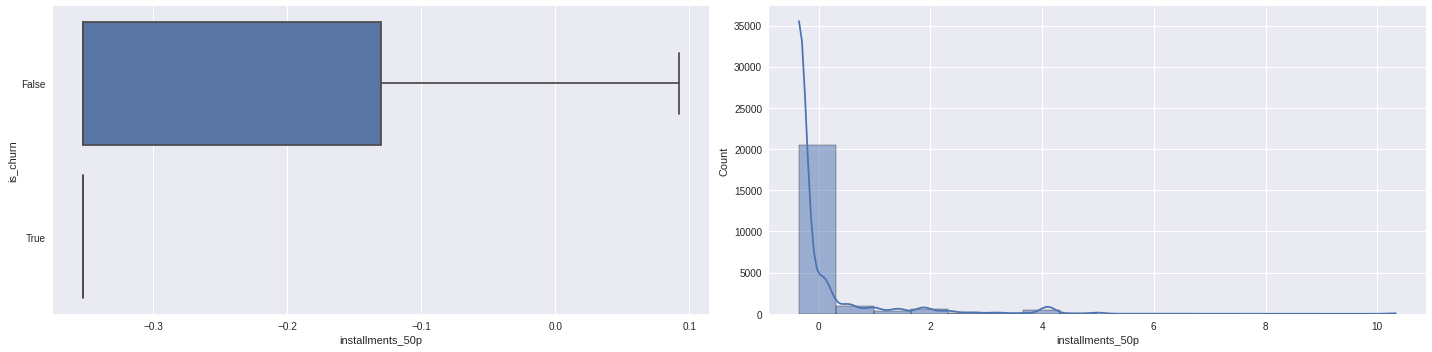

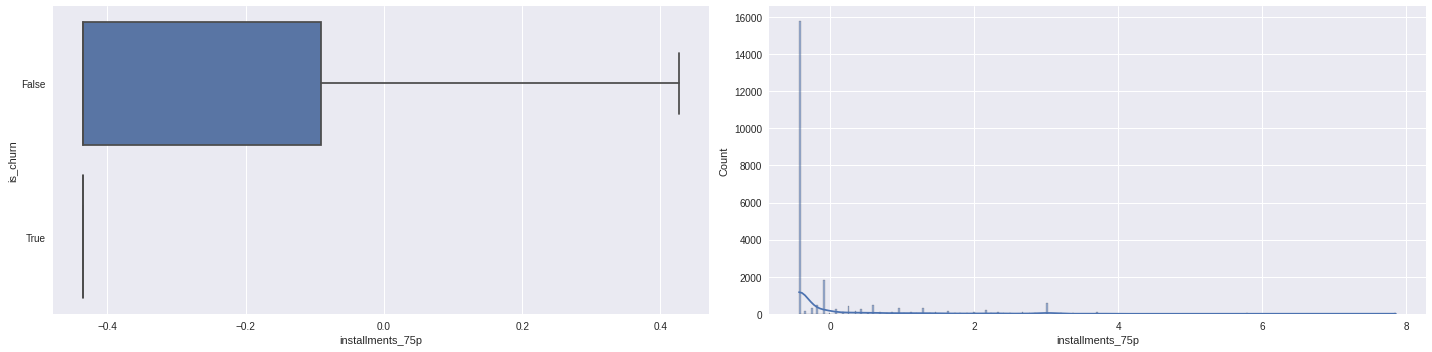

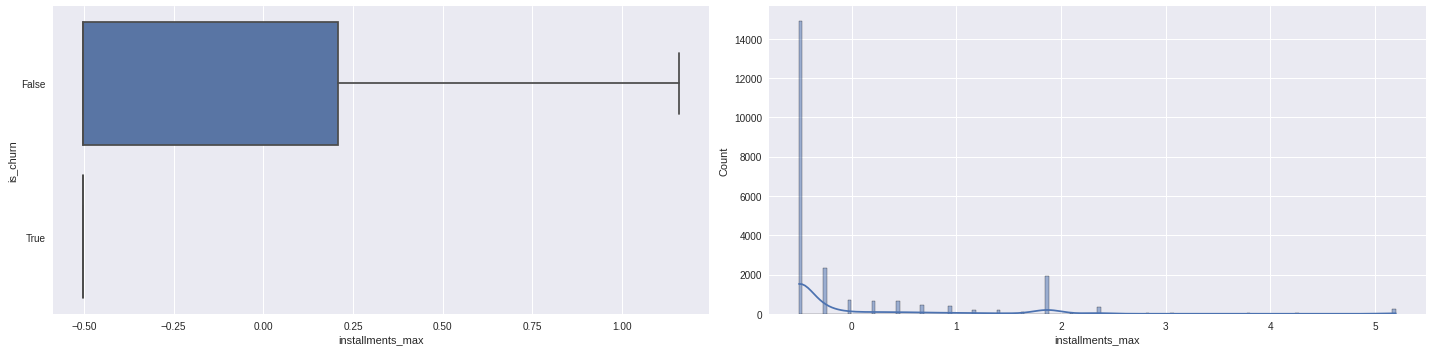

In [ ]:
for col in train_dataset.columns[1:-1]:
    fig, eixo = plt.subplots(1,2,figsize=(20,5))
    sns.boxplot(data=train_dataset, x=col, y="is_churn", orient='h', ax=eixo[0], showfliers=False)
    sns.histplot(data =train_dataset, x=col, ax=eixo[1], kde=True)
    plt.tight_layout()
    plt.show()

### Modelagem:

In [ ]:
X_train = train_dataset.drop('is_churn', axis=1)
y_train = train_dataset['is_churn']
X_test = test_dataset.drop('is_churn', axis=1) 
y_test = test_dataset['is_churn']

In [ ]:
def calculate_far_frr (y_proba, y_true, n_points =100, normalize =True, threshold =None):
    """ Função que calcula os dados para a visualização e gera o gráfico FAR/FRR.

    Parameters
    ----------
    y_true: Series
        Saída esperada (targets).

    y_prob: Series
        Saída probabilística estimada pelo modelo.

    n_points: int (default=100)
        Resolução (quantidade de pontos gerados) do plot.

    normalize: bool (default=True)
        Escolha entre calcular sobre a saída bruta (quantidade de elementos por corte) ou 
        normalizada (percentual de cada dataset).
        
    threshold: float  (default=None)
        Corte usado para a decisão do classificador (predict_proba -> predict).

    Return
    ------

    float
        Corte ótimo (calculado quando `threshold` for None)
    Plot
        Gráfico do FAR/FRR

    """
    
    thr = np.linspace( 0, 1, n_points)
    far = []
    frr = []
    
    for t in thr:
        far_pt = y_proba[y_true == 0][:,1] >= t
        frr_pt = y_proba[y_true == 1][:,1] < t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[ abs(far - frr).argmin()]
    else:
        optm = threshold
    
    plot_data = pd.DataFrame(
        index=thr,
        data={
            'far': far,
            'frr': frr},
        dtype = float)
    
    plt.figure()
   #sns.lineplot(data = plot_data, x=thr, y='far')
    #sns.lineplot(data = plot_data, x=thr, y='frr')
    plot_data['far'].plot(ax=plt.gca(), c='red')
    plot_data['frr'].plot(ax=plt.gca(), c='blue')
    plt.title('FAR / FRR')
    plt.xlabel('Threshold')
    plt.ylabel('Mispredicted')
    plt.axvline(x = optm, color = 'r', linestyle = '--', label=f'decisão (threshold >= {optm*100:5.2f}%)')
    plt.legend()    
    
    return optm

In [ ]:
def metricas_classificação(model_name, model, X_te=X_test, y_te=y_test, X_tr=X_train, y_tr=y_train):
    """ Função que calcula as métricas do modelo de classificação, e retorna o threshold ideal, 
    um dataframe com as métricas de treino e teste, assim como as saídas previstas pelo modelo para os dados de teste.

    Parameters
    ----------
    model_name: String
        Nome do modelo sendo avaliado.
        
    model: Model
        Modelo já fitado sendo avaliado.
    
    X_te: DataFrame (default=X_test)
        Dataframe de teste.
    
    y_te: Series (default=y_test)
        Saída esperada (targets).

    X_tr: DataFrame (default=X_train)
        Dataframe de treino.
    
    y_tr: Series (default=y_train)
        Saída dos dados de treino (targets).

    Return
    ------

    float
        'threshold': Corte ótimo (calculado quando `threshold` for None)
    DataFrame
        'metricas': Métricas de treino e de teste do modelo avaliado
    Series
        'y_pred_test': Dados de testes previdos com o modelo
    Plot
        Gráfico do FAR/FRR

    """
    print("Model: {}\n".format(model_name))
    
    y_proba_test = model.predict_proba(X_te)
    y_proba_train = model.predict_proba(X_tr)
    
    threshold = calculate_far_frr (y_proba_train, y_tr, n_points =100, normalize =True, threshold =None)
    
    y_pred_train = (y_proba_train[:,1] >= threshold).astype(int)
    y_pred_test = (y_proba_test[:,1] >= threshold).astype(int)
    
    accuracy_train =  round(accuracy_score(y_tr, y_pred_train), 4)
    precision_train = round(precision_score(y_tr, y_pred_train), 4)
    recall_train =  round(recall_score(y_tr, y_pred_train), 4)
    f1_train = round(f1_score(y_tr, y_pred_train), 4)
    auc_train = round(roc_auc_score(y_tr, y_pred_train), 4)
    
    train_confusion_matrix = confusion_matrix(y_tr,y_pred_train)
    TN_train = train_confusion_matrix[0][0]
    FP_train = train_confusion_matrix[0][1]
    FN_train = train_confusion_matrix[1][0]
    TP_train = train_confusion_matrix[1][1]
    
    accuracy =  round(accuracy_score(y_te, y_pred_test), 4)
    precision = round(precision_score(y_te, y_pred_test), 4)
    recall =  round(recall_score(y_te, y_pred_test), 4)
    f1 = round(f1_score(y_te, y_pred_test), 4)
    auc = round(roc_auc_score(y_te, y_pred_test), 4)
    
    test_confusion_matrix = confusion_matrix(y_te,y_pred_test)
    TN = test_confusion_matrix[0][0]
    FP = test_confusion_matrix[0][1]
    FN = test_confusion_matrix[1][0]
    TP = test_confusion_matrix[1][1]
    
    metricas = pd.DataFrame({'TN':[TN_train, TN], 
                             'FP':[FP_train, FP],
                             'FN':[FN_train, FN], 
                             'TP':[TP_train, TP], 
                             'Accuracy':[accuracy_train, accuracy],
                             'Precision':[precision_train, precision], 
                             'Recall':[recall_train, recall], 
                             'F1 Score':[f1_train, f1],
                             'AUC':[auc_train, auc]}, 
                            index=[model_name+' Train', model_name])

    print('Treino:')
    print('\nConfusion Matrix') 
    print(train_confusion_matrix)
    print('\n')
    print(classification_report(y_tr,y_pred_train))
    print('\n')
    print('Teste:')
    print('\nConfusion Matrix') 
    print(test_confusion_matrix)
    print('\n')
    print(classification_report(y_te,y_pred_test))
    
    return threshold, y_pred_test, metricas

In [ ]:
dtc_baseline = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [ ]:
dtc_baseline.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

Model: Baseline

Treino:

Confusion Matrix
[[19054    31]
 [    4  4203]]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19085
        True       0.99      1.00      1.00      4207

    accuracy                           1.00     23292
   macro avg       1.00      1.00      1.00     23292
weighted avg       1.00      1.00      1.00     23292



Teste:

Confusion Matrix
[[5203 1165]
 [1103  293]]


              precision    recall  f1-score   support

       False       0.83      0.82      0.82      6368
        True       0.20      0.21      0.21      1396

    accuracy                           0.71      7764
   macro avg       0.51      0.51      0.51      7764
weighted avg       0.71      0.71      0.71      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135


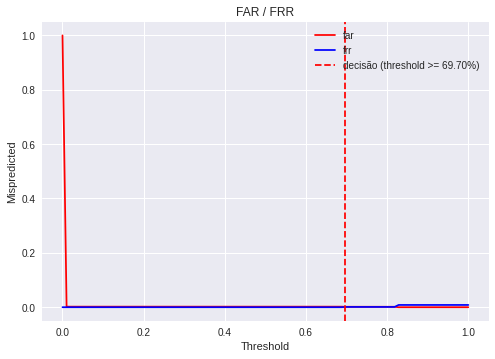

In [ ]:
baseline_threshold, y_pred_baseline, baseline_metricas = metricas_classificação('Baseline', dtc_baseline)
baseline_metricas

In [ ]:
lr = LogisticRegression(random_state=42, solver = 'liblinear', class_weight='balanced')

In [ ]:
param_lr = {'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20)}

gs_lr = RandomizedSearchCV(lr, param_lr, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_params_)
print(gs_lr.best_score_)

{'penalty': 'l2', 'C': 0.004832930238571752}
0.3459297915193712


In [ ]:
lr = LogisticRegression(random_state=42, 
                            solver = 'liblinear',
                            penalty = gs_lr.best_params_['penalty'],
                            C = gs_lr.best_params_['C'],
                            class_weight='balanced')

lr.fit(X_train, y_train)

LogisticRegression(C=0.004832930238571752, class_weight='balanced',
                   random_state=42, solver='liblinear')

Model: LogisticRegression

Treino:

Confusion Matrix
[[11647  7438]
 [ 1812  2395]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.72     19085
        True       0.24      0.57      0.34      4207

    accuracy                           0.60     23292
   macro avg       0.55      0.59      0.53     23292
weighted avg       0.75      0.60      0.65     23292



Teste:

Confusion Matrix
[[3874 2494]
 [ 641  755]]


              precision    recall  f1-score   support

       False       0.86      0.61      0.71      6368
        True       0.23      0.54      0.33      1396

    accuracy                           0.60      7764
   macro avg       0.55      0.57      0.52      7764
weighted avg       0.75      0.60      0.64      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746


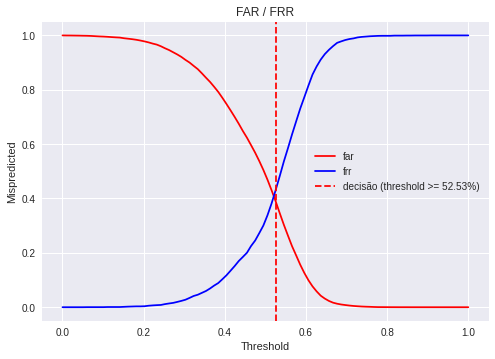

In [ ]:
lr_threshold, y_pred_lr, lr_metricas = metricas_classificação('LogisticRegression', lr)
lr_metricas

In [155]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

In [156]:
param_rfc = {'n_estimators' : [50, 100, 250, 500],
             'max_depth': [5, 10, 15, 20, 25],
             'min_samples_leaf' : [2, 5, 7, 10], 
             'min_samples_split':[2, 5, 7, 10, 15],
             'max_features' : ['sqrt', 0.1,  0.2, 0.3, 0.4, 0.5], 
             'oob_score': [True]}

gs_rfc = RandomizedSearchCV(rfc, param_rfc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_rfc.fit(X_train, y_train)
print(gs_rfc.best_params_)
print(gs_rfc.best_score_)

{'oob_score': True, 'n_estimators': 250, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.4, 'max_depth': 5}
0.3524662252333991


In [157]:
rfc = RandomForestClassifier(random_state=42, 
                             n_estimators = gs_rfc.best_params_['n_estimators'],
                             max_depth = gs_rfc.best_params_['max_depth'], 
                             min_samples_leaf = gs_rfc.best_params_['min_samples_leaf'], 
                             min_samples_split = gs_rfc.best_params_['min_samples_split'], 
                             max_features = gs_rfc.best_params_['max_features'], 
                             oob_score =  gs_rfc.best_params_['oob_score'], 
                             class_weight='balanced')

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.4,
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=250, oob_score=True, random_state=42)

Model: RandomForest

Treino:

Confusion Matrix
[[11762  7323]
 [ 1611  2596]]


              precision    recall  f1-score   support

       False       0.88      0.62      0.72     19085
        True       0.26      0.62      0.37      4207

    accuracy                           0.62     23292
   macro avg       0.57      0.62      0.55     23292
weighted avg       0.77      0.62      0.66     23292



Teste:

Confusion Matrix
[[3849 2519]
 [ 578  818]]


              precision    recall  f1-score   support

       False       0.87      0.60      0.71      6368
        True       0.25      0.59      0.35      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.60      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952


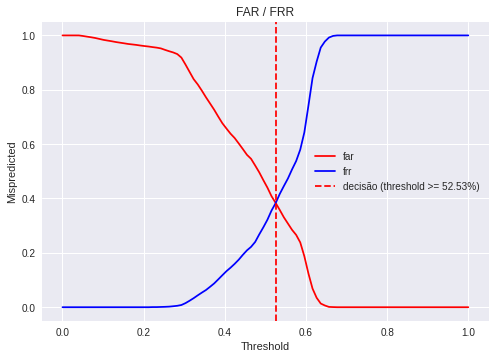

In [158]:
rfc_threshold, y_pred_rfc, rfc_metricas = metricas_classificação('RandomForest', rfc)
rfc_metricas

In [161]:
#svc = SVC(random_state=42, probability=True, class_weight='balanced')

In [162]:
'''param_svc = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}


gs_svc = RandomizedSearchCV(svc, param_svc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_svc.fit(X_train, y_train)
print(gs_svc.best_params_)
print(gs_svc.best_score_)'''

"param_svc = {'C': [0.1, 1, 10, 100, 1000],\n             'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}\n\n\ngs_svc = RandomizedSearchCV(svc, param_svc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\ngs_svc.fit(X_train, y_train)\nprint(gs_svc.best_params_)\nprint(gs_svc.best_score_)"

In [163]:
svc = SVC(random_state=42, 
          probability=True, 
          C=0.0001, #gs_svc.best_params_['C'], 
          gamma=1000,#gs_svc.best_params_['gamma'], 
          class_weight='balanced')

svc.fit(X_train, y_train)

SVC(C=0.0001, class_weight='balanced', gamma=1000, probability=True,
    random_state=42)

Model: SVC

Treino:

Confusion Matrix
[[    0 19085]
 [    0  4207]]


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     19085
        True       0.18      1.00      0.31      4207

    accuracy                           0.18     23292
   macro avg       0.09      0.50      0.15     23292
weighted avg       0.03      0.18      0.06     23292



Teste:

Confusion Matrix
[[   0 6368]
 [   0 1396]]


              precision    recall  f1-score   support

       False       0.00      0.00      0.00      6368
        True       0.18      1.00      0.30      1396

    accuracy                           0.18      7764
   macro avg       0.09      0.50      0.15      7764
weighted avg       0.03      0.18      0.05      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0,0.3060,0.5
SVC,0,6368,0,1396,0.1798,0.1798,1.0,0.3048,0.5


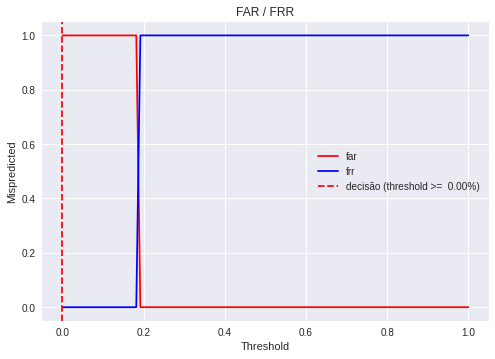

In [164]:
svc_threshold, y_pred_svc, svc_metricas = metricas_classificação('SVC', svc)
svc_metricas

In [168]:
#knn = KNeighborsClassifier()

In [169]:
'''param_knn = {'n_neighbors':[3, 5, 6, 9, 15],
             'leaf_size':[2, 5, 8, 11],
             'p': [1, 2, 4, 6, 8, 10]}

gs_knn = RandomizedSearchCV(knn, param_knn, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_knn.fit(X_train, y_train)
print(gs_knn.best_params_)
print(gs_knn.best_score_)'''

"param_knn = {'n_neighbors':[3, 5, 6, 9, 15],\n             'leaf_size':[2, 5, 8, 11],\n             'p': [1, 2, 4, 6, 8, 10]}\n\ngs_knn = RandomizedSearchCV(knn, param_knn, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\ngs_knn.fit(X_train, y_train)\nprint(gs_knn.best_params_)\nprint(gs_knn.best_score_)"

In [170]:
knn = KNeighborsClassifier(n_neighbors= 3, #gs_knn.best_params_['n_neighbors'] 
                           leaf_size= 2, #gs_knn.best_params_['leaf_size'] 
                           p= 1) #gs_knn.best_params_['p']

knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=2, n_neighbors=3, p=1)

Model: KNN

Treino:

Confusion Matrix
[[13274  5811]
 [    0  4207]]


              precision    recall  f1-score   support

       False       1.00      0.70      0.82     19085
        True       0.42      1.00      0.59      4207

    accuracy                           0.75     23292
   macro avg       0.71      0.85      0.71     23292
weighted avg       0.90      0.75      0.78     23292



Teste:

Confusion Matrix
[[3724 2644]
 [ 738  658]]


              precision    recall  f1-score   support

       False       0.83      0.58      0.69      6368
        True       0.20      0.47      0.28      1396

    accuracy                           0.56      7764
   macro avg       0.52      0.53      0.48      7764
weighted avg       0.72      0.56      0.61      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


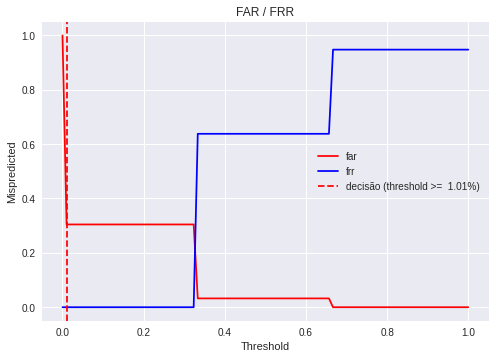

In [171]:
knn_threshold, y_pred_knn, knn_metricas = metricas_classificação('KNN', knn)
knn_metricas

In [172]:
nb = GaussianNB()

In [173]:
param_nb = {'var_smoothing': np.linspace(1e-15, 1e-2, num=10000)}

gs_nb = RandomizedSearchCV(nb, param_nb, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_params_)
print(gs_nb.best_score_)

{'var_smoothing': 0.0033853385338540472}
0.32873842724505653


In [174]:
nb = GaussianNB(var_smoothing=gs_nb.best_params_['var_smoothing'])

nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0033853385338540472)

Model: GaussianNB

Treino:

Confusion Matrix
[[10809  8276]
 [ 1729  2478]]


              precision    recall  f1-score   support

       False       0.86      0.57      0.68     19085
        True       0.23      0.59      0.33      4207

    accuracy                           0.57     23292
   macro avg       0.55      0.58      0.51     23292
weighted avg       0.75      0.57      0.62     23292



Teste:

Confusion Matrix
[[3561 2807]
 [ 591  805]]


              precision    recall  f1-score   support

       False       0.86      0.56      0.68      6368
        True       0.22      0.58      0.32      1396

    accuracy                           0.56      7764
   macro avg       0.54      0.57      0.50      7764
weighted avg       0.74      0.56      0.61      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
GaussianNB Train,10809,8276,1729,2478,0.5705,0.2304,0.5890,0.3313,0.5777
GaussianNB,3561,2807,591,805,0.5623,0.2229,0.5766,0.3215,0.5679


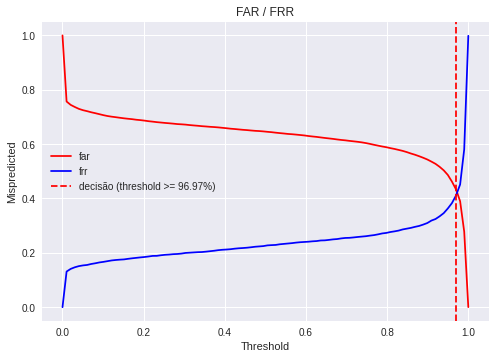

In [175]:
nb_threshold, y_pred_nb, nb_metricas = metricas_classificação('GaussianNB', nb)
nb_metricas

In [178]:
#bag = BaggingClassifier(random_state=42, n_jobs=-1)

In [179]:
'''param_bag = {'n_estimators':[10, 20, 50, 100, 200]}


gs_bag = GridSearchCV(bag, param_bag, cv=5, n_jobs=-1, scoring='f1')
gs_bag.fit(X_train, y_train)
print(gs_bag.best_params_)
print(gs_bag.best_score_)'''

"param_bag = {'n_estimators':[10, 20, 50, 100, 200]}\n\n\ngs_bag = GridSearchCV(bag, param_bag, cv=5, n_jobs=-1, scoring='f1')\ngs_bag.fit(X_train, y_train)\nprint(gs_bag.best_params_)\nprint(gs_bag.best_score_)"

In [180]:
bag = BaggingClassifier(random_state=42, bootstrap=True, n_jobs=-1,
                        n_estimators= 10) #gs_bag.best_params_['n_estimators'])

bag.fit(X_train, y_train)

BaggingClassifier(n_jobs=-1, random_state=42)

Model: Bagging

Treino:

Confusion Matrix
[[18841   244]
 [   53  4154]]


              precision    recall  f1-score   support

       False       1.00      0.99      0.99     19085
        True       0.94      0.99      0.97      4207

    accuracy                           0.99     23292
   macro avg       0.97      0.99      0.98     23292
weighted avg       0.99      0.99      0.99     23292



Teste:

Confusion Matrix
[[5263 1105]
 [1096  300]]


              precision    recall  f1-score   support

       False       0.83      0.83      0.83      6368
        True       0.21      0.21      0.21      1396

    accuracy                           0.72      7764
   macro avg       0.52      0.52      0.52      7764
weighted avg       0.72      0.72      0.72      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Bagging Train,18841,244,53,4154,0.9872,0.9445,0.9874,0.9655,0.9873
Bagging,5263,1105,1096,300,0.7165,0.2135,0.2149,0.2142,0.5207


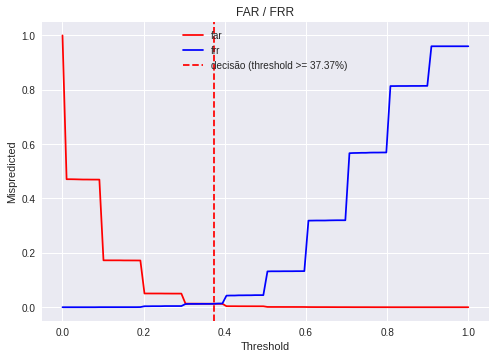

In [181]:
bag_threshold, y_pred_bag, bag_metricas = metricas_classificação('Bagging', bag)
bag_metricas

In [182]:
#ada = AdaBoostClassifier(random_state=42)

In [183]:
'''param_ada = {'n_estimators':[50, 75, 100], 
             'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1]}


gs_ada = GridSearchCV(ada, param_ada, cv=5, n_jobs=-1, scoring='f1')
gs_ada.fit(X_train, y_train)
print(gs_ada.best_params_)
print(gs_ada.best_score_)'''

"param_ada = {'n_estimators':[50, 75, 100], \n             'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1]}\n\n\ngs_ada = GridSearchCV(ada, param_ada, cv=5, n_jobs=-1, scoring='f1')\ngs_ada.fit(X_train, y_train)\nprint(gs_ada.best_params_)\nprint(gs_ada.best_score_)"

In [184]:
ada = AdaBoostClassifier(random_state=42, 
                         n_estimators= 100, #gs_ada.best_params_['n_estimators'], 
                         learning_rate= 1) #gs_ada.best_params_['learning_rate'])
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

Model: AdaBoost

Treino:

Confusion Matrix
[[ 5395 13690]
 [  426  3781]]


              precision    recall  f1-score   support

       False       0.93      0.28      0.43     19085
        True       0.22      0.90      0.35      4207

    accuracy                           0.39     23292
   macro avg       0.57      0.59      0.39     23292
weighted avg       0.80      0.39      0.42     23292



Teste:

Confusion Matrix
[[1724 4644]
 [ 186 1210]]


              precision    recall  f1-score   support

       False       0.90      0.27      0.42      6368
        True       0.21      0.87      0.33      1396

    accuracy                           0.38      7764
   macro avg       0.55      0.57      0.38      7764
weighted avg       0.78      0.38      0.40      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
AdaBoost Train,5395,13690,426,3781,0.3940,0.2164,0.8987,0.3488,0.5907
AdaBoost,1724,4644,186,1210,0.3779,0.2067,0.8668,0.3338,0.5687


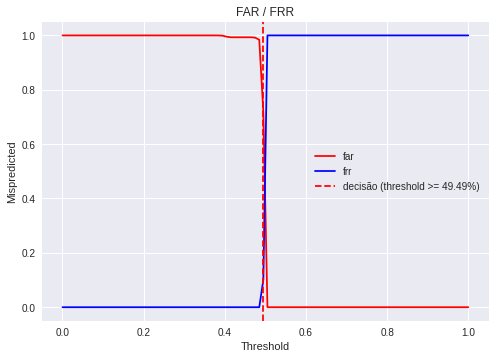

In [185]:
ada_threshold, y_pred_ada, ada_metricas = metricas_classificação('AdaBoost', ada)
ada_metricas

In [186]:
#gbc = GradientBoostingClassifier(random_state=42)

In [187]:
'''param_gbc = {'learning_rate':np.linspace(0.01, 1, 50), 
             'n_estimators':[100, 200, 500, 1000], 
             'subsample':[0.2, 0.3, 0.4, 0.5, 0.7], 
             'max_depth':[1, 2, 3, 5, 7], 
             'max_features':['sqrt', 0.2, 0.4, 0.5]}


param_gbc = RandomizedSearchCV(gbc, param_gbc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
param_gbc.fit(X_train, y_train)
print(param_gbc.best_params_)
print(param_gbc.best_score_)'''

"param_gbc = {'learning_rate':np.linspace(0.01, 1, 50), \n             'n_estimators':[100, 200, 500, 1000], \n             'subsample':[0.2, 0.3, 0.4, 0.5, 0.7], \n             'max_depth':[1, 2, 3, 5, 7], \n             'max_features':['sqrt', 0.2, 0.4, 0.5]}\n\n\nparam_gbc = RandomizedSearchCV(gbc, param_gbc, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\nparam_gbc.fit(X_train, y_train)\nprint(param_gbc.best_params_)\nprint(param_gbc.best_score_)"

In [188]:
gbc = GradientBoostingClassifier(random_state=42, 
                                 learning_rate= 0.7979591836734694, #param_gbc.best_params_['learning_rate'], 
                                 n_estimators= 1000, #param_gbc.best_params_['n_estimators'], 
                                 subsample= 0.2, #param_gbc.best_params_['subsample'], 
                                 max_depth= 3, #param_gbc.best_params_['max_depth'], 
                                 max_features= 0.2) #param_gbc.best_params_['max_features'])
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7979591836734694, max_features=0.2,
                           n_estimators=1000, random_state=42, subsample=0.2)

Model: GradientBoosting

Treino:

Confusion Matrix
[[ 6664 12421]
 [ 1337  2870]]


              precision    recall  f1-score   support

       False       0.83      0.35      0.49     19085
        True       0.19      0.68      0.29      4207

    accuracy                           0.41     23292
   macro avg       0.51      0.52      0.39     23292
weighted avg       0.72      0.41      0.46     23292



Teste:

Confusion Matrix
[[2243 4125]
 [ 462  934]]


              precision    recall  f1-score   support

       False       0.83      0.35      0.49      6368
        True       0.18      0.67      0.29      1396

    accuracy                           0.41      7764
   macro avg       0.51      0.51      0.39      7764
weighted avg       0.71      0.41      0.46      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
GradientBoosting Train,6664,12421,1337,2870,0.4093,0.1877,0.6822,0.2944,0.5157
GradientBoosting,2243,4125,462,934,0.4092,0.1846,0.6691,0.2894,0.5106


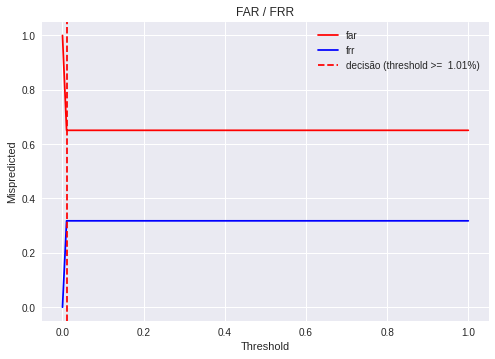

In [189]:
gbc_threshold, y_pred_gbc, gbc_metricas = metricas_classificação('GradientBoosting', gbc)
gbc_metricas

In [190]:
#lgbm = LGBMClassifier(objective='binary',random_state=42, class_weight='balanced')

In [191]:
'''param_lgbm = {'num_leaves':[30, 50, 100, 150], 
              'max_depth':[5, 7, 10, 15],
              'learning_rate':np.linspace(0.01, 0.5, 50),
              'n_estimators':[100, 200, 500, 1000]}

gs_lgbm = RandomizedSearchCV(lgbm, param_lgbm, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_lgbm.fit(X_train, y_train)
print(gs_lgbm.best_params_)
print(gs_lgbm.best_score_)'''

"param_lgbm = {'num_leaves':[30, 50, 100, 150], \n              'max_depth':[5, 7, 10, 15],\n              'learning_rate':np.linspace(0.01, 0.5, 50),\n              'n_estimators':[100, 200, 500, 1000]}\n\ngs_lgbm = RandomizedSearchCV(lgbm, param_lgbm, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\ngs_lgbm.fit(X_train, y_train)\nprint(gs_lgbm.best_params_)\nprint(gs_lgbm.best_score_)"

In [194]:
lgbm = LGBMClassifier(objective='binary',
                       random_state=42,
                       num_leaves = 100, #gs_lgbm.best_params_['num_leaves'], 
                       max_depth = 5, #gs_lgbm.best_params_['max_depth'], 
                       learning_rate = 0.03, #gs_lgbm.best_params_['learning_rate'], 
                       n_estimators = 100, class_weight='balanced') #gs_lgbm.best_params_['n_estimators'], 
lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.03, max_depth=5,
               num_leaves=100, objective='binary', random_state=42)

Model: LGBM

Treino:

Confusion Matrix
[[11967  7118]
 [ 1464  2743]]


              precision    recall  f1-score   support

       False       0.89      0.63      0.74     19085
        True       0.28      0.65      0.39      4207

    accuracy                           0.63     23292
   macro avg       0.58      0.64      0.56     23292
weighted avg       0.78      0.63      0.67     23292



Teste:

Confusion Matrix
[[3859 2509]
 [ 589  807]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.71      6368
        True       0.24      0.58      0.34      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.59      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
LGBM Train,11967,7118,1464,2743,0.6315,0.2782,0.6520,0.3900,0.6395
LGBM,3859,2509,589,807,0.6010,0.2434,0.5781,0.3425,0.5920


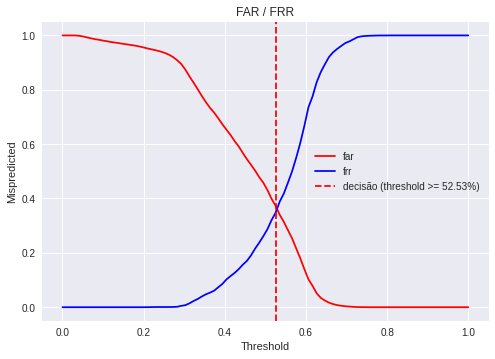

In [195]:
lgbm_threshold, y_pred_lgbm, lgbm_metricas = metricas_classificação('LGBM', lgbm)
lgbm_metricas

In [196]:
#xgb = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric = 'logloss')

In [197]:
'''param_xgb = {'max_depth':[3, 5, 7, 10, 15],
             'learning_rate':np.linspace(0.01, 0.7, 50),
             'n_estimators':[100, 500, 1000, 2000],
             'eta': np.linspace(0.1, 1, 50), 
             'colsample_bytree':np.linspace(0.1, 0.7, 50)}

gs_xgb = RandomizedSearchCV(xgb, param_xgb, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)
gs_xgb.fit(X_train, y_train)
print(gs_xgb.best_params_)
print(gs_xgb.best_score_)'''

"param_xgb = {'max_depth':[3, 5, 7, 10, 15],\n             'learning_rate':np.linspace(0.01, 0.7, 50),\n             'n_estimators':[100, 500, 1000, 2000],\n             'eta': np.linspace(0.1, 1, 50), \n             'colsample_bytree':np.linspace(0.1, 0.7, 50)}\n\ngs_xgb = RandomizedSearchCV(xgb, param_xgb, cv=5, n_iter=20, n_jobs=-1, scoring='f1', random_state=42)\ngs_xgb.fit(X_train, y_train)\nprint(gs_xgb.best_params_)\nprint(gs_xgb.best_score_)"

In [198]:
xgb = XGBClassifier(objective='binary:logistic', 
                    random_state=42, 
                    eval_metric = 'logloss', 
                    max_depth = 7, #gs_xgb.best_params_['max_depth'],
                    learning_rate = 0.643673469387755, #gs_xgb.best_params_['learning_rate'], 
                    n_estimators = 2000, #gs_xgb.best_params_['n_estimators'],
                    eta = 0.8163265306122449, #gs_xgb.best_params_['eta'], 
                    colsample_bytree = 0.3938775510204081) #gs_xgb.best_params_['colsample_bytree'])
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.3938775510204081, eta=0.8163265306122449,
              eval_metric='logloss', learning_rate=0.643673469387755,
              max_depth=7, n_estimators=2000, random_state=42)

Model: XGBoost

Treino:

Confusion Matrix
[[19056    29]
 [    6  4201]]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19085
        True       0.99      1.00      1.00      4207

    accuracy                           1.00     23292
   macro avg       1.00      1.00      1.00     23292
weighted avg       1.00      1.00      1.00     23292



Teste:

Confusion Matrix
[[5772  596]
 [1235  161]]


              precision    recall  f1-score   support

       False       0.82      0.91      0.86      6368
        True       0.21      0.12      0.15      1396

    accuracy                           0.76      7764
   macro avg       0.52      0.51      0.51      7764
weighted avg       0.71      0.76      0.73      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
XGBoost Train,19056,29,6,4201,0.9985,0.9931,0.9986,0.9959,0.9985
XGBoost,5772,596,1235,161,0.7642,0.2127,0.1153,0.1496,0.5109


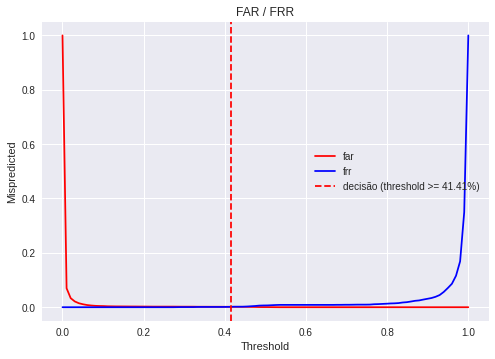

In [199]:
xgb_threshold, y_pred_xgb, xgb_metricas = metricas_classificação('XGBoost', xgb)
xgb_metricas

In [200]:
metrics = pd.concat([baseline_metricas, lr_metricas, rfc_metricas, svc_metricas, knn_metricas, nb_metricas, bag_metricas, 
                     ada_metricas, gbc_metricas, lgbm_metricas, xgb_metricas])

In [201]:
metrics

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0000,0.3060,0.5000
SVC,0,6368,0,1396,0.1798,0.1798,1.0000,0.3048,0.5000
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


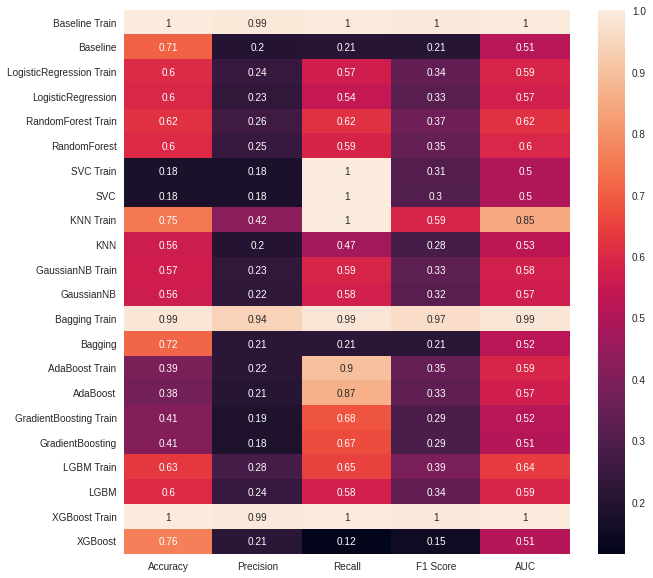

In [202]:
plt.figure(figsize=(10,10))
sns.heatmap(metrics.iloc[:,4:], annot=True)
plt.show()

Com base nesta comparação, os modelos Baseline, KNN, Bagging e XGBoost overfitaram.
Os demais modelos serão ordenados por F1 Score de teste.

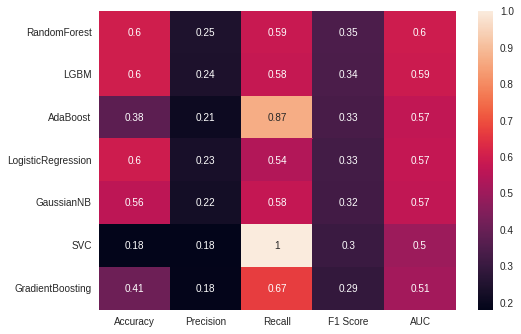

In [203]:
sns.heatmap(metrics.loc[['LogisticRegression', 'RandomForest', 'SVC', 'GaussianNB', 'AdaBoost', 'GradientBoosting', 'LGBM'],
                        ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']].sort_values('F1 Score', ascending=False),
            annot=True)
plt.show()

A melhor performance obtida foi do LGBM, seguido por RandomForest, AdaBoost e LogisticRegression.

### Ensembles:

In [204]:
models_list = [
    'LogisticRegression',
    'RandomForest', 
    'AdaBoost', 
    'LGBM' 
]

In [205]:
potencial_ensemble = pd.DataFrame({'Target': y_test,
                                   'LogisticRegression':y_pred_lr,
                                  'RandomForest': y_pred_rfc,
                                  'AdaBoost': y_pred_ada,
                                  'LGBM': y_pred_lgbm
                                  })

potencial_ensemble = potencial_ensemble.astype(int)

In [206]:
potencial_ensemble

,Target,LogisticRegression,RandomForest,AdaBoost,LGBM
client_id,,,,,
cx06840,0,0,1,1,1
cx01931,0,0,1,1,1
cx35431,0,1,1,1,1
cx36233,0,1,1,1,1
cx13540,0,1,1,1,1
...,...,...,...,...,...
cx19119,0,0,0,1,0
cx21963,0,1,1,1,1
cx37195,0,1,1,1,1


In [207]:
potencial_ensemble['Previsão Ótima'] = np.nan

for col in models_list:
  for i in range(len(potencial_ensemble)):
    if potencial_ensemble['Previsão Ótima'][i] == potencial_ensemble.Target[i]:
        pass
    elif (potencial_ensemble[col][i] == potencial_ensemble.Target[i]) and (potencial_ensemble['Previsão Ótima'][i] != potencial_ensemble.Target[i]):
        potencial_ensemble['Previsão Ótima'][i] = potencial_ensemble[col][i]
    elif (potencial_ensemble[col][i] != potencial_ensemble.Target[i]) and (potencial_ensemble['Previsão Ótima'][i] != potencial_ensemble.Target[i]):
        potencial_ensemble['Previsão Ótima'][i] = potencial_ensemble[col][i]

In [208]:
row = {'LogisticRegression' : f1_score(potencial_ensemble.Target, potencial_ensemble['LogisticRegression']),
       'RandomForest' : f1_score(potencial_ensemble.Target, potencial_ensemble['RandomForest']),
       'AdaBoost': f1_score(potencial_ensemble.Target, potencial_ensemble['AdaBoost']),
       'LGBM': f1_score(potencial_ensemble.Target, potencial_ensemble['LGBM']),
       'Previsão Ótima' : f1_score(potencial_ensemble.Target, potencial_ensemble['Previsão Ótima'])}

In [209]:
potencial_ensemble = potencial_ensemble.append(row, ignore_index=True)

In [210]:
potencial_ensemble

,Target,LogisticRegression,RandomForest,AdaBoost,LGBM,Previsão Ótima
0,0.0,0.000000,1.000000,1.000000,1.00000,0.000000
1,0.0,0.000000,1.000000,1.000000,1.00000,0.000000
2,0.0,1.000000,1.000000,1.000000,1.00000,1.000000
3,0.0,1.000000,1.000000,1.000000,1.00000,1.000000
4,0.0,1.000000,1.000000,1.000000,1.00000,1.000000
...,...,...,...,...,...,...
7760,0.0,1.000000,1.000000,1.000000,1.00000,1.000000
7761,0.0,1.000000,1.000000,1.000000,1.00000,1.000000
7762,0.0,0.000000,0.000000,1.000000,0.00000,0.000000
7763,1.0,0.000000,0.000000,0.000000,0.00000,0.000000


Assim, a combinação ótima dos 4 modelos poderia elevar a performance para 0.54, o que demonstra que os modelos foram capazes de realizar previsões diferentes, captando diferentes nuancias dos dados.

Os modelos Logistic Regression, Random Forest, AdaBoost e LGBM serão utilizados em um Ensemble de Voting e em um Stacking.

In [211]:
voting = VotingClassifier(estimators=[
                                      ('LogisticRegression', lr),
                                      ('RandomForest', rfc),
                                      ('AdaBoost', ada),
                                      ('LGBM', lgbm)
], voting ='soft')

In [212]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=0.004832930238571752,
                                                 class_weight='balanced',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_features=0.4,
                                                     min_samples_leaf=2,
                                                     min_samples_split=7,
                                                     n_estimators=250,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('AdaBoost',
  

Model: Voting

Treino:

Confusion Matrix
[[11465  7620]
 [ 1492  2715]]


              precision    recall  f1-score   support

       False       0.88      0.60      0.72     19085
        True       0.26      0.65      0.37      4207

    accuracy                           0.61     23292
   macro avg       0.57      0.62      0.54     23292
weighted avg       0.77      0.61      0.65     23292



Teste:

Confusion Matrix
[[3763 2605]
 [ 549  847]]


              precision    recall  f1-score   support

       False       0.87      0.59      0.70      6368
        True       0.25      0.61      0.35      1396

    accuracy                           0.59      7764
   macro avg       0.56      0.60      0.53      7764
weighted avg       0.76      0.59      0.64      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Voting Train,11465,7620,1492,2715,0.6088,0.2627,0.6454,0.3734,0.6230
Voting,3763,2605,549,847,0.5938,0.2454,0.6067,0.3494,0.5988


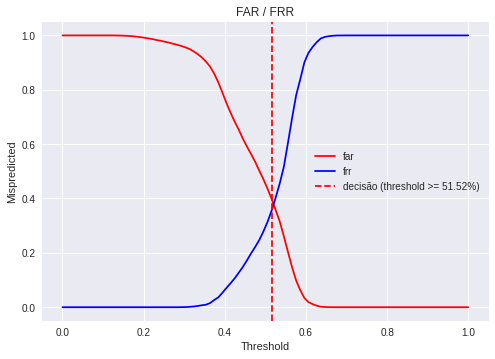

In [213]:
voting_threshold, y_pred_voting, voting_metricas = metricas_classificação('Voting', voting)
voting_metricas

In [214]:
stacking = StackingClassifier(estimators=[
                                      ('LogisticRegression', lr),
                                      ('RandomForest', rfc),
                                      ('AdaBoost', ada),
                                      ('LGBM', lgbm)
], stack_method ='predict_proba')

In [215]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('LogisticRegression',
                                LogisticRegression(C=0.004832930238571752,
                                                   class_weight='balanced',
                                                   random_state=42,
                                                   solver='liblinear')),
                               ('RandomForest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features=0.4,
                                                       min_samples_leaf=2,
                                                       min_samples_split=7,
                                                       n_estimators=250,
                                                       oob_score=True,
                                                       random_state=42)),
                

Model: Stacking

Treino:

Confusion Matrix
[[11854  7231]
 [ 1581  2626]]


              precision    recall  f1-score   support

       False       0.88      0.62      0.73     19085
        True       0.27      0.62      0.37      4207

    accuracy                           0.62     23292
   macro avg       0.57      0.62      0.55     23292
weighted avg       0.77      0.62      0.66     23292



Teste:

Confusion Matrix
[[3863 2505]
 [ 582  814]]


              precision    recall  f1-score   support

       False       0.87      0.61      0.71      6368
        True       0.25      0.58      0.35      1396

    accuracy                           0.60      7764
   macro avg       0.56      0.59      0.53      7764
weighted avg       0.76      0.60      0.65      7764



,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Stacking Train,11854,7231,1581,2626,0.6217,0.2664,0.6242,0.3734,0.6227
Stacking,3863,2505,582,814,0.6024,0.2453,0.5831,0.3453,0.5949


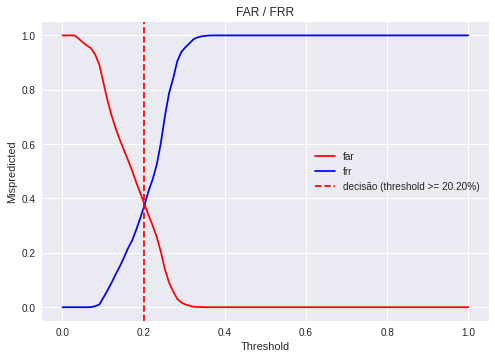

In [216]:
stacking_threshold, y_pred_stacking, stacking_metricas = metricas_classificação('Stacking', stacking)
stacking_metricas

In [217]:
final_results = pd.concat([metrics, voting_metricas, stacking_metricas])

In [218]:
final_results

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,AUC
Baseline Train,19054,31,4,4203,0.9985,0.9927,0.9990,0.9959,0.9987
Baseline,5203,1165,1103,293,0.7079,0.2010,0.2099,0.2053,0.5135
LogisticRegression Train,11647,7438,1812,2395,0.6029,0.2436,0.5693,0.3412,0.5898
LogisticRegression,3874,2494,641,755,0.5962,0.2324,0.5408,0.3251,0.5746
RandomForest Train,11762,7323,1611,2596,0.6164,0.2617,0.6171,0.3675,0.6167
RandomForest,3849,2519,578,818,0.6011,0.2451,0.5860,0.3457,0.5952
SVC Train,0,19085,0,4207,0.1806,0.1806,1.0000,0.3060,0.5000
SVC,0,6368,0,1396,0.1798,0.1798,1.0000,0.3048,0.5000
KNN Train,13274,5811,0,4207,0.7505,0.4199,1.0000,0.5915,0.8478
KNN,3724,2644,738,658,0.5644,0.1993,0.4713,0.2801,0.5281


In [219]:
results_index = [indice for indice in final_results.index.tolist() if 'Train' not in indice]

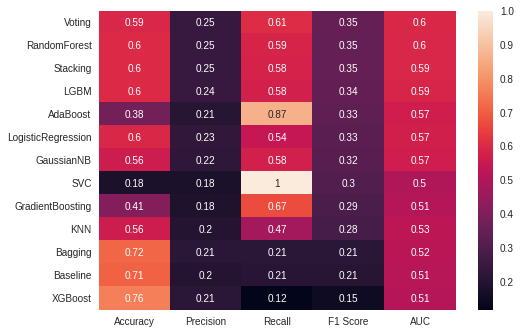

In [220]:
sns.heatmap(final_results.loc[results_index,
                              ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']].sort_values('F1 Score', 
                                                                                                  ascending=False),
            annot=True)
plt.show()

O modelo Voting foi capaz de ter a melhor performance nos dados de teste, obtendo o maior F1 Score.

In [222]:
y_proba_challenge = voting.predict_proba(challenge_dataset)
y_pred_challenge = voting.predict(challenge_dataset)

In [223]:
y_pred_challenge = (y_proba_challenge[:,1] >= voting_threshold).astype(int)

In [224]:
resultado = pd.concat([challenge_dataset.reset_index(), 
                       pd.Series(y_pred_challenge)], axis=1)

In [225]:
resultado = resultado.rename(columns={0:'is_churn'})

In [226]:
resultado = resultado[['client_id', 'is_churn']].copy().set_index('client_id')

In [227]:
resultado.to_csv('resultado_ensembles.csv')